<a href="https://colab.research.google.com/github/aimalz/CASTORpz/blob/main/CASTOR_TLM_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
from google.colab import drive
drive.mount('/content/drive')

from astropy.table import Table
prepend = '/content/drive/MyDrive/Research/CASTORpz/'
unp = Table.read(prepend+"unperturbed_mags.fits")
print(len(unp))

# !pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install jaxlib==0.4.16
!pip install jax==0.4.16

# jaxlib==0.3.22+cuda11.cudnn82

# !pip install jax[cuda]==0.4.17+cuda12.cudnn89 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

# !pip install "jax[cuda]"==0.4.16
!nvcc --version

!pip install astropy pzflow corner

from pzflow import Flow
import jax.numpy as jnp
import pandas as pd
import numpy as np
import pickle
import corner
import matplotlib.pyplot as plt
from astropy.table import Table
from pzflow import Flow, FlowEnsemble
from pzflow.distributions import Uniform
from pzflow.bijectors import Chain, StandardScaler, NeuralSplineCoupling, ColorTransform, InvSoftplus, RollingSplineCoupling, ShiftBounds

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
698211
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [3]:
cd /content/drive/MyDrive/Research/CASTORpz


/content/drive/MyDrive/Research/CASTORpz


In [4]:
unp = Table.read(prepend+"unperturbed_mags.fits").to_pandas()#.set_index('ID')
mock = Table.read(prepend+"ext_phot.fits").to_pandas()#.set_index('ID')

In [5]:
names_phot = ["ID", "photoz",
              "LSST_g_MAG", "LSST_g_MAGERR",
              "LSST_r_MAG", "LSST_r_MAGERR",
              "LSST_i_MAG", "LSST_i_MAGERR",
              "LSST_z_MAG", "LSST_z_MAGERR",
              "castor_uv_MAG", "castor_uv_MAGERR",
              "castor_u_MAG", "castor_u_MAGERR",
              "castor_g_MAG", "castor_g_MAGERR",
              "Euclid_VIS_MAG",
              'Euclid_Y_MAG','Euclid_J_MAG','Euclid_H_MAG',
              'Roman_106_MAG',
              'Roman_129_MAG','Roman_158_MAG',
              'Roman_184_MAG']



available_os = ["CASTOR-only", "LSST-only", "Euclid-only", #"Roman-only",
"LSST+CASTOR", "Euclid+CASTOR", #"Roman+CASTOR",
"Euclid+LSST", "Euclid+LSST+CASTOR"
]

Roman_os = ["Roman-only", "Roman+CASTOR", "Roman+Euclid+LSST+CASTOR", "Roman+LSST"]

available_os = available_os + Roman_os
print(available_os)

names = available_os

['CASTOR-only', 'LSST-only', 'Euclid-only', 'LSST+CASTOR', 'Euclid+CASTOR', 'Euclid+LSST', 'Euclid+LSST+CASTOR', 'Roman-only', 'Roman+CASTOR', 'Roman+Euclid+LSST+CASTOR', 'Roman+LSST']


In [6]:
# load data
def getTrueY(test_cat, mag_col_names, y_col_name):
    test_cat = Table(test_cat, masked=True, copy=True)
    # remove nans
    for col in mag_col_names:
        test_cat[col].mask = np.isnan(test_cat[col].data) | test_cat[col].mask
        test_cat = test_cat[~test_cat[col].mask] # then remove nans from test set

    true_y = test_cat[y_col_name]
    return true_y.filled()

In [7]:
# want to read in here the cleaned catalogs that have been saved elsewhere

In [8]:
ls

all_combos_histogram.pdf
all_combos_over_z.pdf
color_space_plots.pdf
ext_phot.fits
Feb_ensembles/
Feb_experiments/
filters/
intro_plots.ipynb
knn_colors.py
losses_for_CASTOR-only.pkl
losses_for_Euclid+CASTOR.pkl
losses_for_Euclid+LSST+CASTOR.pkl
losses_for_Euclid+LSST.pkl
losses_for_Euclid-only.pkl
losses_for_LSST+CASTOR.pkl
losses_for_LSST-only.pkl
losses_for_Roman+CASTOR.pkl
losses_for_Roman+Euclid+LSST+CASTOR.pkl
losses_for_Roman+Euclid+LSST.pkl
losses_for_Roman+LSST.pkl
losses_for_Roman-only.pkl
Mar_experiments/
May_flows/
new_main_fig.pdf
Oct_flows/
Oct_flows_draft/
Oct_flows_draftpzflow_ensemble_for_CASTOR-only.pkl
Oct_flows_draftpzflow_ensemble_for_Euclid+CASTOR.pkl
Oct_flows_draftpzflow_ensemble_for_Euclid+LSST.pkl
Oct_flows_draftpzflow_ensemble_for_Euclid-only.pkl
Oct_flows_draftpzflow_ensemble_for_LSST+CASTOR.pkl
Oct_flows_draftpzflow_ensemble_for_LSST-only.pkl
Oct_flows_draftpzflow_ensemble_for_Roman+Euclid+LSST+CASTOR.pkl
Oct_flows_draftpzflow_ensemble_for_Roman+Euclid+LSST

In [9]:
available_os = ['LSST-only',
                'CASTOR-only',
                'Euclid+LSST',
                'LSST+CASTOR',
                'Roman+Euclid+LSST',
                'Roman+Euclid+LSST+CASTOR']

os_combo_labels = {'LSST-only': 'LSST',
                  'CASTOR-only': 'CASTOR',
                  'LSST+CASTOR': 'LSST+CASTOR',
                  'Roman+LSST': 'LSST+Roman',
                  # 'Roman+LSST+CASTOR' : 'LSST+Roman+CASTOR', #(currently training, will be in Mar_experiments)
                  'Roman+Euclid+LSST': 'LSST+Roman+Euclid',
                  'Roman+Euclid+LSST+CASTOR': 'LSST+Roman+Euclid+CASTOR'}

# what I actually want is LSST + Roman
# and LSST + Roman + Euclid
# rerunning now

In [10]:
ls *.pkl

losses_for_CASTOR-only.pkl
losses_for_Euclid+CASTOR.pkl
losses_for_Euclid+LSST+CASTOR.pkl
losses_for_Euclid+LSST.pkl
losses_for_Euclid-only.pkl
losses_for_LSST+CASTOR.pkl
losses_for_LSST-only.pkl
losses_for_Roman+CASTOR.pkl
losses_for_Roman+Euclid+LSST+CASTOR.pkl
losses_for_Roman+Euclid+LSST.pkl
losses_for_Roman+LSST.pkl
losses_for_Roman-only.pkl
Oct_flows_draftpzflow_ensemble_for_CASTOR-only.pkl
Oct_flows_draftpzflow_ensemble_for_Euclid+CASTOR.pkl
Oct_flows_draftpzflow_ensemble_for_Euclid+LSST.pkl
Oct_flows_draftpzflow_ensemble_for_Euclid-only.pkl
Oct_flows_draftpzflow_ensemble_for_LSST+CASTOR.pkl
Oct_flows_draftpzflow_ensemble_for_LSST-only.pkl
Oct_flows_draftpzflow_ensemble_for_Roman+Euclid+LSST+CASTOR.pkl
Oct_flows_draftpzflow_ensemble_for_Roman+Euclid+LSST.pkl
Oct_flowspzflow_ensemble_for_CASTOR-only.pkl
Oct_flowspzflow_ensemble_for_Euclid+CASTOR.pkl
Oct_flowspzflow_ensemble_for_Euclid+LSST+CASTOR.pkl
Oct_flowspzflow_ensemble_for_Euclid+LSST.pkl
Oct_flowspzflow_ensemble_for_Euclid

In [11]:
flows = {}
for os in available_os:
  flows[os] = FlowEnsemble(file=f"Oct_flows_draftpzflow_ensemble_for_{os}.pkl")

In [12]:
flows['LSST-only'].data_columns

['z_true']

In [13]:
# grid = jnp.linspace(0, 4, 100)

# pdfs = flows['LSST-only'].posterior(catalogs['LSST-only'], column="z_true", grid=grid)

In [14]:
# plt.plot(grid, pdfs[4])
# plt.xlabel("$x$")
# plt.ylabel("$p(x|y=0.78)$")
# plt.show()

In [15]:
mock_cat = pd.merge(mock, unp[['ID',"Euclid_VIS_MAG"]], on='ID')

In [16]:
CASTOR_baseline = Table.from_pandas(mock_cat[(mock_cat["Euclid_VIS_MAG"] <= 24.5) & (mock_cat["LSST_r_MAG"] >= 17.5)]) # apply magnitude limit cuts

In [17]:
# put data in expected format for TLM

LSST_g_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_g_MAG")
LSST_r_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_r_MAG")
LSST_i_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_i_MAG")
LSST_z_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_z_MAG")

# LSST_g_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_g_MAGERR")
# LSST_r_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_r_MAGERR")
# LSST_i_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_i_MAGERR")
# LSST_z_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_z_MAGERR")

CASTOR_g_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_g_MAG")
CASTOR_u_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_u_MAG")
CASTOR_uv_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_uv_MAG")

# CASTOR_g_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_g_MAGERR")
# CASTOR_u_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_u_MAGERR")
# CASTOR_uv_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_uv_MAGERR")

Euclid_VIS_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="Euclid_VIS_MAG")
Euclid_J_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="Euclid_J_MAG")
Euclid_H_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="Euclid_H_MAG")
Euclid_Y_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="Euclid_Y_MAG")

# Roman - only a subset of the Roman filters are available?

# Roman_062_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_062_MAG')
# Roman_087_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_087_MAG')
Roman_106_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_106_MAG')

Roman_129_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_129_MAG')
# Roman_146_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_146_MAG')
Roman_158_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_158_MAG')

Roman_184_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_184_MAG')
# Roman_213_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_213_MAG')

ID = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="ID")
z_true = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="photoz")

In [18]:
# get magnitudes and set up the catalogs

catalogs = dict()
catalogs['LSST+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true,
                             'r': LSST_r_mag,
                             'g-r': LSST_g_mag - LSST_r_mag,
                             'r-i': LSST_r_mag - LSST_i_mag,
                             'i-z': LSST_i_mag - LSST_z_mag,
                             'uv-u': CASTOR_uv_mag - CASTOR_u_mag,
                             'u-g': CASTOR_u_mag - CASTOR_g_mag
                      }).set_index('CASTOR_ID').dropna()
catalogs['LSST-only'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true,
                             'r': LSST_r_mag,
                             'g-r': LSST_g_mag - LSST_r_mag,
                             'r-i': LSST_r_mag - LSST_i_mag,
                             'i-z': LSST_i_mag - LSST_z_mag
                      }).set_index('CASTOR_ID').dropna()
catalogs['CASTOR-only'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true,
                             'g': CASTOR_g_mag,
                             'uv-u': CASTOR_uv_mag - CASTOR_u_mag,
                             'u-g': CASTOR_u_mag - CASTOR_g_mag
                      }).set_index('CASTOR_ID').dropna()
catalogs['Euclid-only'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true,
                             'v': Euclid_VIS_mag,
                             'v-y': Euclid_VIS_mag - Euclid_Y_mag,
                             'y-j': Euclid_Y_mag - Euclid_J_mag,
                             'j-h': Euclid_J_mag - Euclid_H_mag
                      }).set_index('CASTOR_ID').dropna()

catalogs['Euclid+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true,
                             'g': CASTOR_g_mag,
                             'uv-u': CASTOR_uv_mag - CASTOR_u_mag,
                             'u-g': CASTOR_u_mag - CASTOR_g_mag,
                             'v': Euclid_VIS_mag,
                             'v-y': Euclid_VIS_mag - Euclid_Y_mag,
                             'y-j': Euclid_Y_mag - Euclid_J_mag,
                             'j-h': Euclid_J_mag - Euclid_H_mag
                      }).set_index('CASTOR_ID').dropna()
catalogs['Euclid+LSST'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true,
                              'r': LSST_r_mag,
                             'g-r': LSST_g_mag - LSST_r_mag,
                             'r-i': LSST_r_mag - LSST_i_mag,
                             'i-z': LSST_i_mag - LSST_z_mag,
                             'v': Euclid_VIS_mag,
                             'v-y': Euclid_VIS_mag - Euclid_Y_mag,
                             'y-j': Euclid_Y_mag - Euclid_J_mag,
                             'j-h': Euclid_J_mag - Euclid_H_mag
                      }).set_index('CASTOR_ID').dropna()
catalogs['Euclid+LSST+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true,
                              'r': LSST_r_mag,
                             'g-r': LSST_g_mag - LSST_r_mag,
                             'r-i': LSST_r_mag - LSST_i_mag,
                             'i-z': LSST_i_mag - LSST_z_mag,
                             'v': Euclid_VIS_mag,
                             'v-y': Euclid_VIS_mag - Euclid_Y_mag,
                             'y-j': Euclid_Y_mag - Euclid_J_mag,
                             'j-h': Euclid_J_mag - Euclid_H_mag,
                             'g': CASTOR_g_mag,
                             'uv-u': CASTOR_uv_mag - CASTOR_u_mag,
                             'u-g': CASTOR_u_mag - CASTOR_g_mag
                      }).set_index('CASTOR_ID').dropna()

catalogs["Roman+Euclid+LSST+CASTOR"] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true,
                             'r': LSST_r_mag,
                             'g-r': LSST_g_mag - LSST_r_mag,
                             'r-i': LSST_r_mag - LSST_i_mag,
                             'i-z': LSST_i_mag - LSST_z_mag,
                             'v': Euclid_VIS_mag,
                             'v-y': Euclid_VIS_mag - Euclid_Y_mag,
                             'y-j': Euclid_Y_mag - Euclid_J_mag,
                             'j-h': Euclid_J_mag - Euclid_H_mag,
                             'g': CASTOR_g_mag,
                             'uv-u': CASTOR_uv_mag - CASTOR_u_mag,
                             'u-g': CASTOR_u_mag - CASTOR_g_mag,
                             '106': Roman_106_mag,
                             '129 - 106': Roman_129_mag - Roman_106_mag,
                             '158-129': Roman_158_mag - Roman_129_mag,
                             '184-158': Roman_184_mag - Roman_158_mag
                      }).set_index('CASTOR_ID').dropna()

catalogs["Roman+Euclid+LSST"] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true,
                             'r': LSST_r_mag,
                             'g-r': LSST_g_mag - LSST_r_mag,
                             'r-i': LSST_r_mag - LSST_i_mag,
                             'i-z': LSST_i_mag - LSST_z_mag,
                             'v': Euclid_VIS_mag,
                             'v-y': Euclid_VIS_mag - Euclid_Y_mag,
                             'y-j': Euclid_Y_mag - Euclid_J_mag,
                             'j-h': Euclid_J_mag - Euclid_H_mag,
                             '106': Roman_106_mag,
                             '129 - 106': Roman_129_mag - Roman_106_mag,
                             '158-129': Roman_158_mag - Roman_129_mag,
                             '184-158': Roman_184_mag - Roman_158_mag
                      }).set_index('CASTOR_ID').dropna()

In [19]:
# available_os = ['LSST-only',
#                 'CASTOR-only',
#                 'Euclid+CASTOR',
# #                 'LSST+CASTOR']

available_os = ['LSST-only',
                'CASTOR-only',
                'Euclid+LSST',
                'LSST+CASTOR',
                'Roman+Euclid+LSST',
                'Roman+Euclid+LSST+CASTOR']

just_tav = {}
for os in available_os:
  just_tav[os] = flows[os].log_prob(catalogs[os])

### Checking information due to each band

In [ ]:
cd Feb_experiments

/content/drive/.shortcut-targets-by-id/16x7U5T_UymL5W1hrOq7ELHaADZbsYBNb/CASTORpz/Feb_experiments


In [ ]:
flows_drops = {}
# flows_drops['drop_v'] = FlowEnsemble(file=f"pzflow_ensemble_for_Euclid+LSST_drop_v.pkl")
# flows_drops['drop_h'] = FlowEnsemble(file=f"pzflow_ensemble_for_Euclid+LSST_drop_h.pkl")
# flows_drops['drop_j'] = FlowEnsemble(file=f"pzflow_ensemble_for_Euclid+LSST_drop_j.pkl")
# flows_drops['drop_y'] = FlowEnsemble(file=f"pzflow_ensemble_for_Euclid+LSST_drop_y.pkl")

# TODO: would like to run these maybe?
# flows_drops['drop_106'] = FlowEnsemble(file=f"pzflow_ensemble_for_Roman+LSST_drop_106.pkl")
# flows_drops['drop_129'] = FlowEnsemble(file=f"pzflow_ensemble_for_Roman+LSST_drop_129.pkl")
# flows_drops['drop_158'] = FlowEnsemble(file=f"pzflow_ensemble_for_Roman+LSST_drop_158.pkl")
# flows_drops['drop_184'] = FlowEnsemble(file=f"pzflow_ensemble_for_Roman+LSST_drop_184.pkl")

flows_drops['drop_uv'] = FlowEnsemble(file=f"pzflow_ensemble_for_LSST+CASTOR_drop_uv.pkl")
flows_drops['drop_u'] = FlowEnsemble(file=f"pzflow_ensemble_for_LSST+CASTOR_drop_u.pkl")
flows_drops['drop_g'] = FlowEnsemble(file=f"pzflow_ensemble_for_LSST+CASTOR_drop_g.pkl")


In [ ]:
just_tav_drops = {}
# just_tav_drops['LSST-only'] = just_tav['LSST-only']
# just_tav_drops['CASTOR-only'] = just_tav['CASTOR-only']

# catalogs['Euclid+LSST'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true,
#                               'r': LSST_r_mag,
#                              'g-r': LSST_g_mag - LSST_r_mag,
#                              'r-i': LSST_r_mag - LSST_i_mag,
#                              'i-z': LSST_i_mag - LSST_z_mag,
#                              'v': Euclid_VIS_mag,
#                              'y': Euclid_Y_mag,
#                              'j':  Euclid_J_mag,
#                              'h':  Euclid_H_mag
#                       }).set_index('CASTOR_ID').dropna()

catalogs['LSST+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true,
                             'r': LSST_r_mag,
                             'g-r': LSST_g_mag - LSST_r_mag,
                             'r-i': LSST_r_mag - LSST_i_mag,
                             'i-z': LSST_i_mag - LSST_z_mag,
                             'uv': CASTOR_uv_mag,
                              'u':   CASTOR_u_mag,
                             'g': CASTOR_g_mag
                      }).set_index('CASTOR_ID').dropna()

# just_tav['drop_v'] = flows_drops['drop_v'].log_prob(catalogs['Euclid+LSST'])
# just_tav['drop_y'] = flows_drops['drop_y'].log_prob(catalogs['Euclid+LSST'])
# just_tav['drop_j'] = flows_drops['drop_j'].log_prob(catalogs['Euclid+LSST'])
# just_tav['drop_h'] = flows_drops['drop_h'].log_prob(catalogs['Euclid+LSST'])

just_tav_drops['drop_uv'] = flows_drops['drop_uv'].log_prob(catalogs['LSST+CASTOR'])
just_tav_drops['drop_u'] = flows_drops['drop_u'].log_prob(catalogs['LSST+CASTOR'])
just_tav_drops['drop_g'] = flows_drops['drop_g'].log_prob(catalogs['LSST+CASTOR'])


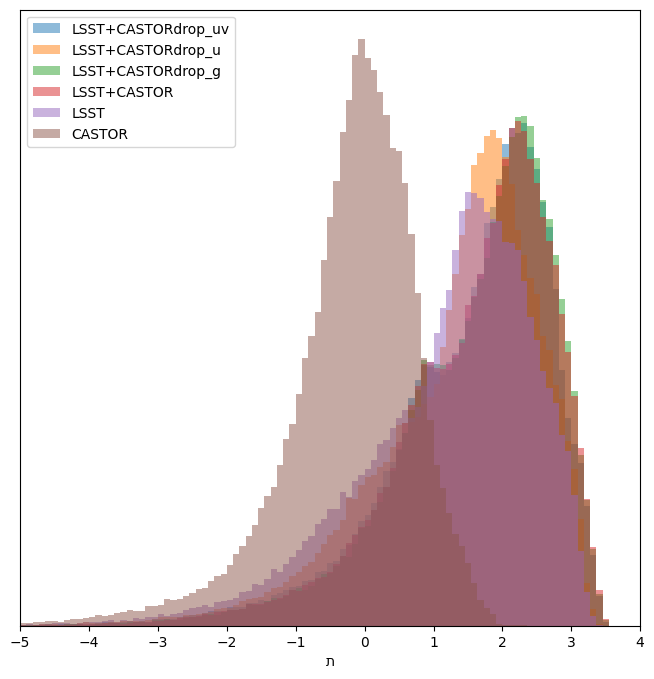

In [ ]:
fig = plt.figure(figsize = (8, 8))

# for drop in  ['drop_v', 'drop_y', 'drop_j', 'drop_h']:
#   plt.hist(just_tav_drops[drop], alpha=0.25, label=drop, density=True, bins=np.linspace(-5, 4, 100))
#   plt.legend()
#   plt.xlim(-5,4)
#   plt.ylim(0, 0.6)
#   plt.xlabel(chr(0x05ea))#r'$\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]$')
#   plt.yticks([])
# plt.show()

# drop_plot_colors = {'drop_uv': }
#TODO try plotting this with borders only and hardcoded colors
for drop in  ['drop_uv', 'drop_u', 'drop_g']:
  plt.hist(just_tav_drops[drop], label=os_combo_labels['LSST+CASTOR']+drop, density=True, alpha=0.5, linewidth=0.5, bins=np.linspace(-5, 4, 100))
plt.hist(just_tav['LSST+CASTOR'], label=os_combo_labels['LSST+CASTOR'], density=True, alpha=0.5, linewidth=0.5, bins=np.linspace(-5, 4, 100))
plt.hist(just_tav['LSST-only'], label=os_combo_labels['LSST-only'], density=True, alpha=0.5, linewidth=0.5, bins=np.linspace(-5, 4, 100))
plt.hist(just_tav['CASTOR-only'], label=os_combo_labels['CASTOR-only'], density=True, alpha=0.5, linewidth=0.5, bins=np.linspace(-5, 4, 100))
plt.legend()
plt.xlim(-5,4)
# plt.ylim(0, 0.6)
plt.xlabel(chr(0x05ea))#r'$\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]$')
plt.yticks([])
plt.show()

In [ ]:
import scipy.stats as sps


In [ ]:
b = sps.mstats.mquantiles(z_true, np.linspace(0,1,101, endpoint=True))


all_tlm = {}
all_milb = {}
all_ent = {}
is_inf_mask = {}

for drop in  ['drop_v', 'drop_y', 'drop_j', 'drop_h']:
    # print(os_names[os])
    # load the photometric catalog for this os
    cat = catalogs['Euclid+LSST']

  # Computing the entropy H(z)
    pz = sps.rv_histogram(np.histogram(z_true, bins=b))
    entropy = pz.entropy()
    # just checking that this isn't discrete entropy and that binning doesn't need to match anything else
    # testent = sum(-1 * pz.logpdf(b_centers) * pz.pdf(b_centers) * db)
    # print(entropy - testent)
    all_ent['Euclid+LSST'] = entropy



  # Computing lower bound
    # all_milb = []
    # print(len(flows[os]))
    # for i in range(10):
    milb = flows[drop].log_prob(cat, returnEnsemble=True, err_samples=10)# + entropy
    print(np.sum(np.isinf(milb)))
    print(np.sum(np.isnan(milb)))
    print(np.shape(milb[0,:]))
    # print(milb)
    all_milb[drop] = np.array(milb)
    # print(np.shape(all_milb[os]))
    all_tlm[drop] = milb.mean(axis=1) + entropy
    is_inf_mask[drop] = np.isinf(all_tlm[drop])
    all_tlm[drop] = all_tlm[drop][~np.isinf(all_tlm[drop])]
    print(np.sum(np.isinf(all_tlm[drop])))

<ipython-input-34-8351950dc940>:15: RuntimeWarning: Bin widths are not constant. Assuming `density=True`.Specify `density` explicitly to silence this warning.
  pz = sps.rv_histogram(np.histogram(z_true, bins=b))


0
0
(20,)
0


<ipython-input-34-8351950dc940>:15: RuntimeWarning: Bin widths are not constant. Assuming `density=True`.Specify `density` explicitly to silence this warning.
  pz = sps.rv_histogram(np.histogram(z_true, bins=b))


0
0
(20,)
0


<ipython-input-34-8351950dc940>:15: RuntimeWarning: Bin widths are not constant. Assuming `density=True`.Specify `density` explicitly to silence this warning.
  pz = sps.rv_histogram(np.histogram(z_true, bins=b))


0
0
(20,)
0


<ipython-input-34-8351950dc940>:15: RuntimeWarning: Bin widths are not constant. Assuming `density=True`.Specify `density` explicitly to silence this warning.
  pz = sps.rv_histogram(np.histogram(z_true, bins=b))


1
0
(20,)
0


In [ ]:
zbins = np.linspace(0, 3, 100)
avgtav = {}
errtav = {}
for drop in  ['drop_v', 'drop_y', 'drop_j']:
  print(drop)
  plotran = np.empty_like(zbins)
  ploterr = np.empty_like(zbins)
  print(catalogs[os].columns)
  catalogs['Euclid+LSST'][drop] = all_tlm[drop]
  print(catalogs['Euclid+LSST'].columns)

  for i, zmin in enumerate(zbins[:-1]):
    zmax = zbins[i+1]
    subset = catalogs['Euclid+LSST'][(catalogs['Euclid+LSST']['z_true'] >= zmin) & (catalogs['Euclid+LSST']['z_true'] < zmax)]
    # print((zmin, len(subset), zmax))
    vals = subset[drop]
    mean = np.mean(vals)
    std = np.std(vals)
    plotran[i] = mean
    ploterr[i] = std

  print(len(plotran))
  avgtav[drop] = plotran
  errtav[drop] = ploterr

drop_v
Index(['z_true', 'r', 'g-r', 'r-i', 'i-z'], dtype='object')
Index(['z_true', 'r', 'g-r', 'r-i', 'i-z', 'v', 'y', 'j', 'h', 'logprob',
       'drop_v', 'drop_y', 'drop_j'],
      dtype='object')
100
drop_y
Index(['z_true', 'r', 'g-r', 'r-i', 'i-z'], dtype='object')
Index(['z_true', 'r', 'g-r', 'r-i', 'i-z', 'v', 'y', 'j', 'h', 'logprob',
       'drop_v', 'drop_y', 'drop_j'],
      dtype='object')
100
drop_j
Index(['z_true', 'r', 'g-r', 'r-i', 'i-z'], dtype='object')
Index(['z_true', 'r', 'g-r', 'r-i', 'i-z', 'v', 'y', 'j', 'h', 'logprob',
       'drop_v', 'drop_y', 'drop_j'],
      dtype='object')
100


0
5.26871e-318
0
4.735076e-318
0
4.735076e-318


(-1.0, 5.0)

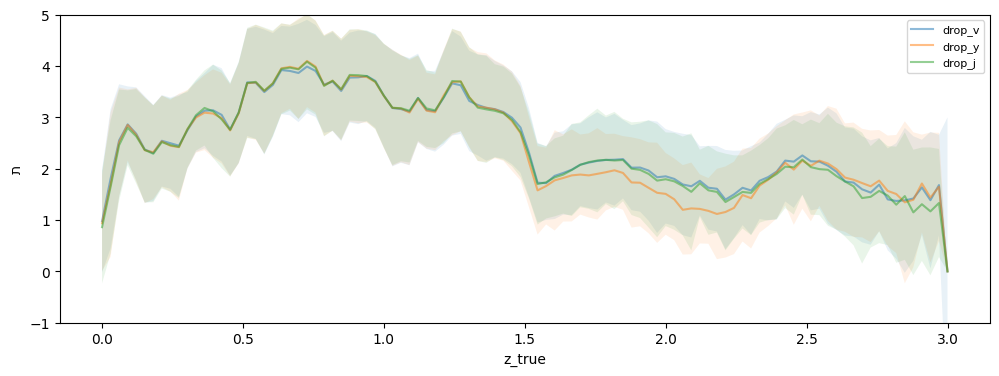

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (12, 4))

for drop in ['drop_v', 'drop_y', 'drop_j']:
  print(np.sum(np.isinf(avgtav[drop])))
  print(np.min(avgtav[drop]))
  ax.plot(zbins, avgtav[drop], label=drop, alpha=0.5)
  ax.fill_between(zbins, avgtav[drop] - errtav[drop], avgtav[drop] + errtav[drop], alpha = 0.1)
# plt.ylim(-10, 5)
ax.legend(fontsize = 8)
ax.set_xlabel('z_true')
ax.set_ylabel(chr(0x05ea))
ax.set_ylim(-1, 5)

In [ ]:
b = sps.mstats.mquantiles(z_true, np.linspace(0,1,101, endpoint=True))


all_tlm = {}
all_milb = {}
all_ent = {}
is_inf_mask = {}

for drop in  ['drop_uv', 'drop_u', 'drop_g']:
    # print(os_names[os])
    # load the photometric catalog for this os
    cat = catalogs['LSST+CASTOR']

  # Computing the entropy H(z)
    pz = sps.rv_histogram(np.histogram(z_true, bins=b))
    entropy = pz.entropy()
    # just checking that this isn't discrete entropy and that binning doesn't need to match anything else
    # testent = sum(-1 * pz.logpdf(b_centers) * pz.pdf(b_centers) * db)
    # print(entropy - testent)
    all_ent['LSST+CASTOR'] = entropy



  # Computing lower bound
    # all_milb = []
    # print(len(flows[os]))
    # for i in range(10):
    milb = flows[drop].log_prob(cat, returnEnsemble=True, err_samples=10)# + entropy
    print(np.sum(np.isinf(milb)))
    print(np.sum(np.isnan(milb)))
    print(np.shape(milb[0,:]))
    # print(milb)
    all_milb[drop] = np.array(milb)
    # print(np.shape(all_milb[os]))
    all_tlm[drop] = milb.mean(axis=1) + entropy
    # is_inf_mask[drop] = np.isinf(all_tlm[drop])
    # all_tlm[drop] = all_tlm[drop][~is_inf_mask[drop]]
    # cat = cat[~is_inf_mask[drop]]
    # print(np.sum(np.isinf(all_tlm[drop])))

<ipython-input-66-a821ec07c2e1>:15: RuntimeWarning: Bin widths are not constant. Assuming `density=True`.Specify `density` explicitly to silence this warning.
  pz = sps.rv_histogram(np.histogram(z_true, bins=b))


0
0
(20,)


<ipython-input-66-a821ec07c2e1>:15: RuntimeWarning: Bin widths are not constant. Assuming `density=True`.Specify `density` explicitly to silence this warning.
  pz = sps.rv_histogram(np.histogram(z_true, bins=b))


1
0
(20,)


<ipython-input-66-a821ec07c2e1>:15: RuntimeWarning: Bin widths are not constant. Assuming `density=True`.Specify `density` explicitly to silence this warning.
  pz = sps.rv_histogram(np.histogram(z_true, bins=b))


0
0
(20,)


drop_uv
Index(['z_true', 'r', 'g-r', 'r-i', 'i-z', 'uv', 'u', 'g', 'drop_uv', 'drop_u',
       'drop_g'],
      dtype='object')
Index(['z_true', 'r', 'g-r', 'r-i', 'i-z', 'uv', 'u', 'g', 'drop_uv', 'drop_u',
       'drop_g'],
      dtype='object')
100
drop_u
Index(['z_true', 'r', 'g-r', 'r-i', 'i-z', 'uv', 'u', 'g', 'drop_uv', 'drop_u',
       'drop_g'],
      dtype='object')
Index(['z_true', 'r', 'g-r', 'r-i', 'i-z', 'uv', 'u', 'g', 'drop_uv', 'drop_u',
       'drop_g'],
      dtype='object')
100
drop_g
Index(['z_true', 'r', 'g-r', 'r-i', 'i-z', 'uv', 'u', 'g', 'drop_uv', 'drop_u',
       'drop_g'],
      dtype='object')
Index(['z_true', 'r', 'g-r', 'r-i', 'i-z', 'uv', 'u', 'g', 'drop_uv', 'drop_u',
       'drop_g'],
      dtype='object')
100
0
5.26871e-318
1
-inf
0
4.735076e-318


(-1.0, 5.0)

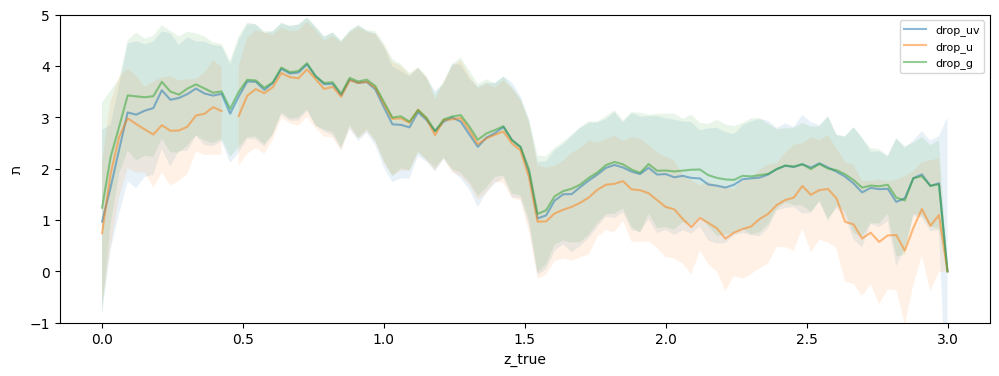

In [ ]:
zbins = np.linspace(0, 3, 100)
avgtav = {}
errtav = {}
for drop in  ['drop_uv', 'drop_u', 'drop_g']:
  print(drop)
  plotran = np.empty_like(zbins)
  ploterr = np.empty_like(zbins)
  print(catalogs['LSST+CASTOR'].columns)
  catalogs['LSST+CASTOR'][drop] = all_tlm[drop]
  print(catalogs['LSST+CASTOR'].columns)

  for i, zmin in enumerate(zbins[:-1]):
    zmax = zbins[i+1]
    subset = catalogs['LSST+CASTOR'][(catalogs['LSST+CASTOR']['z_true'] >= zmin) & (catalogs['LSST+CASTOR']['z_true'] < zmax)]
    # print((zmin, len(subset), zmax))
    vals = subset[drop]
    mean = np.mean(vals)
    std = np.std(vals)
    plotran[i] = mean
    ploterr[i] = std

  print(len(plotran))
  avgtav[drop] = plotran
  errtav[drop] = ploterr

fig, ax = plt.subplots(1, 1, figsize = (12, 4))

for drop in ['drop_uv', 'drop_u', 'drop_g']:
  print(np.sum(np.isinf(avgtav[drop])))
  print(np.min(avgtav[drop]))
  ax.plot(zbins, avgtav[drop], label=drop, alpha=0.5)
  ax.fill_between(zbins, avgtav[drop] - errtav[drop], avgtav[drop] + errtav[drop], alpha = 0.1)
# plt.ylim(-10, 5)
ax.legend(fontsize = 8)
ax.set_xlabel('z_true')
ax.set_ylabel(chr(0x05ea))
ax.set_ylim(-1, 5)

In [ ]:
# comment from Steve - could this be a depth effect - CASTOR is several magnitudes deeper than Euclid/Roman. overlap with LSST u-band

In [ ]:
print(len(just_tav['drop_uv']))
print(len(just_tav['drop_u']))
print(len(just_tav['drop_g']))

108838
108838
108838


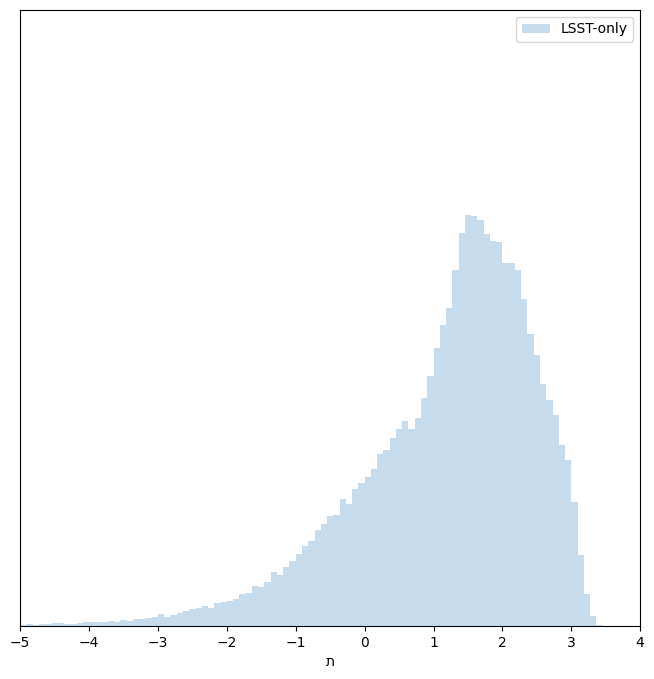

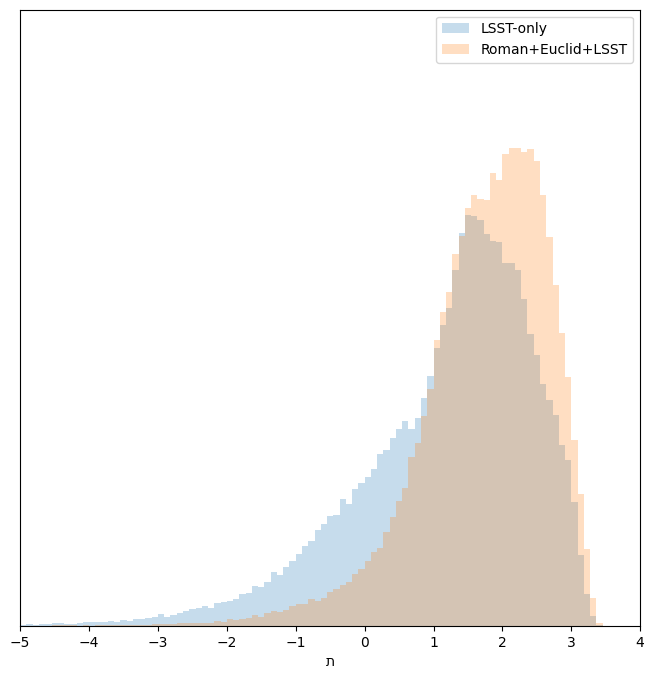

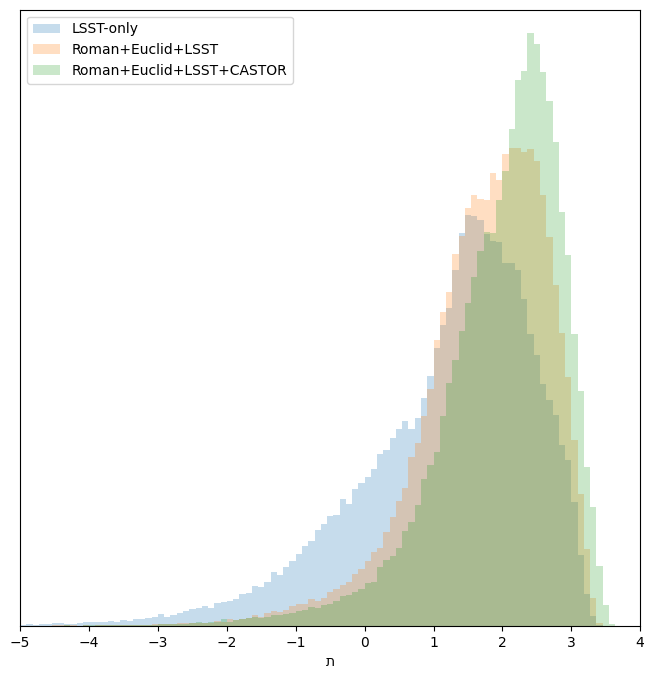

In [ ]:
fig = plt.figure(figsize = (8, 8))

plot_os = ['LSST-only']

for os in plot_os:
  plt.hist(just_tav[os], alpha=0.25, label=os, density=True, bins=np.linspace(-5, 4, 100))
  plt.legend()
  plt.xlim(-5,4)
  plt.ylim(0, 0.6)
  plt.xlabel(chr(0x05ea))#r'$\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]$')
  plt.yticks([])

plt.savefig('theory_group_talk_1.png')
plt.show()

# plot_os = ['LSST-only',
#            'Euclid+LSST']

# fig = plt.figure(figsize = (8, 8))

# for os in plot_os:
#   plt.hist(just_tav[os], alpha=0.25, label=os, density=True, bins=np.linspace(-5, 4, 100))
#   plt.legend()
#   plt.xlim(-5,4)
#   plt.xlabel(chr(0x05ea))#r'$\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]$')
#   plt.yticks([])
# plt.show()

plot_os = ['LSST-only',
           'Roman+Euclid+LSST']

fig = plt.figure(figsize = (8, 8))

for os in plot_os:
  plt.hist(just_tav[os], alpha=0.25, label=os, density=True, bins=np.linspace(-5, 4, 100))
  plt.legend()
  plt.xlim(-5,4)
  plt.ylim(0, 0.6)
  plt.xlabel(chr(0x05ea))#r'$\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]$')
  plt.yticks([])

plt.savefig('theory_group_talk_2.png')
plt.show()

plot_os = ['LSST-only',
           'Roman+Euclid+LSST',
           'Roman+Euclid+LSST+CASTOR']

fig = plt.figure(figsize = (8, 8))

for os in plot_os:
  plt.hist(just_tav[os], alpha=0.25, label=os, density=True, bins=np.linspace(-5, 4, 100))
  plt.legend()
  plt.xlim(-5,4)
  plt.ylim(0, 0.6)
  plt.xlabel(chr(0x05ea))#r'$\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]$')
  plt.yticks([])

plt.savefig('theory_group_talk_3.png')
plt.show()

In [ ]:
available_os

['LSST-only',
 'CASTOR-only',
 'Euclid+LSST',
 'LSST+CASTOR',
 'Roman+Euclid+LSST',
 'Roman+Euclid+LSST+CASTOR']

In [ ]:
# available_os = ['LSST-only',
#                 'CASTOR-only',
#                 'Euclid+CASTOR',
#                 'LSST+CASTOR']

available_os = ['LSST-only',
                'CASTOR-only',
                'Euclid+LSST',
                'LSST+CASTOR',
                'Roman+Euclid+LSST',
                'Roman+Euclid+LSST+CASTOR']

just_tav = {}
for os in available_os:
  just_tav[os] = flows[os].log_prob(catalogs[os])

In [ ]:
least_improved_Euclid = np.argsort((np.abs(just_tav['LSST-only'] - just_tav['Euclid+LSST'])))[::-1]
least_improved_CASTOR = np.argsort((np.abs(just_tav['LSST-only'] - just_tav['LSST+CASTOR'])))[::-1]

most_improved_Euclid = np.argsort((np.abs(just_tav['LSST-only'] - just_tav['Euclid+LSST'])))
most_improved_CASTOR = np.argsort((np.abs(just_tav['LSST-only'] - just_tav['LSST+CASTOR'])))

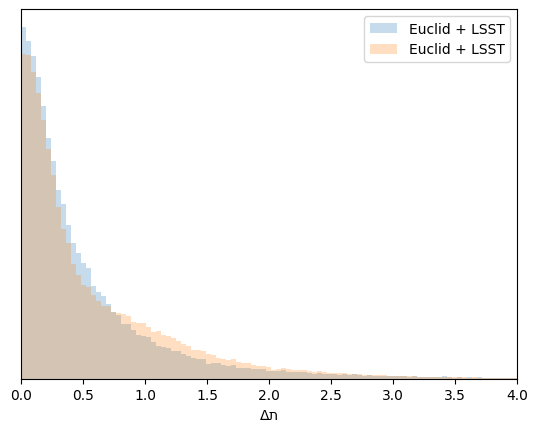

In [ ]:
plt.hist(np.abs(just_tav['LSST-only'] - just_tav['Euclid+LSST']), alpha=0.25, label= 'Euclid + LSST', density=True, bins=np.linspace(0, 4, 100))
plt.hist(np.abs(just_tav['LSST-only'] - just_tav['LSST+CASTOR']), alpha=0.25, label= 'Euclid + LSST', density=True, bins=np.linspace(0, 4, 100))

plt.legend()
plt.xlim(0, 4)
plt.xlabel(r'$\Delta$' + chr(0x05ea)) #r'$\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]$')
plt.yticks([])
plt.show()

In [ ]:
worst_galaxies_Euclid = np.argsort((np.abs(just_tav['Euclid+LSST'])))[::-1][0:1000]
worst_galaxies_CASTOR = np.argsort((np.abs(just_tav['LSST+CASTOR'])))[::-1][0:1000]

best_galaxies_Euclid = np.argsort((np.abs(just_tav['Euclid+LSST'])))[0:1000]
best_galaxies_CASTOR = np.argsort((np.abs(just_tav['LSST+CASTOR'])))[0:1000]

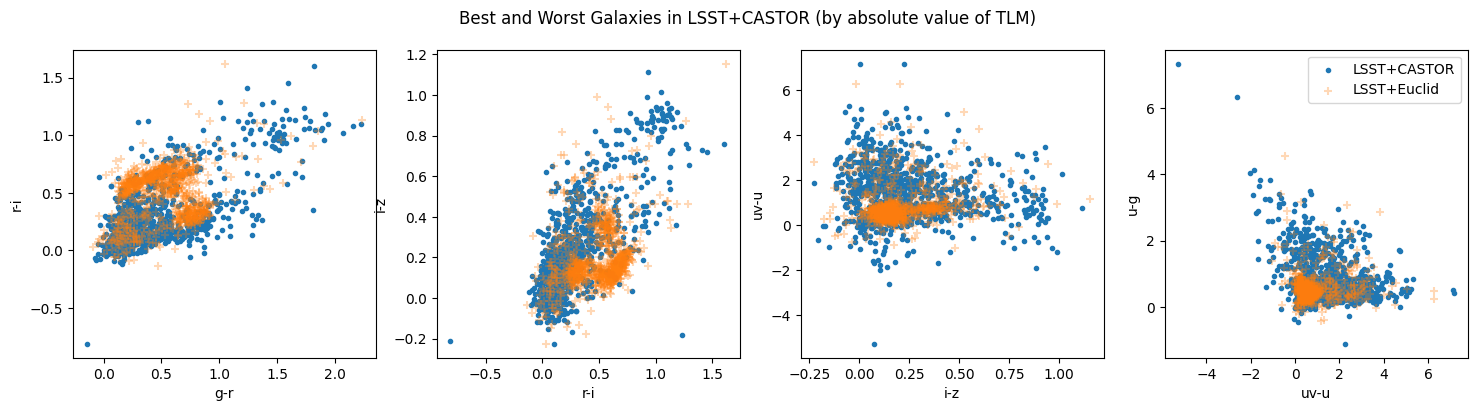

In [ ]:
fig, ax = plt.subplots(1, 4, figsize = (18, 4))

i=1

colors_lsst = ['g-r', 'r-i', 'i-z', 'uv-u', 'u-g']

plt.suptitle('Best and Worst Galaxies in LSST+CASTOR (by absolute value of TLM)')

for color, ax in zip(colors_lsst, ax.reshape(-1)):
  ax.scatter(np.array(catalogs['LSST+CASTOR'][color])[best_galaxies_CASTOR], np.array(catalogs['LSST+CASTOR'][colors_lsst[i]])[best_galaxies_CASTOR], label = 'LSST+CASTOR', marker = '.')
  ax.scatter(np.array(catalogs['LSST+CASTOR'][color])[worst_galaxies_CASTOR], np.array(catalogs['LSST+CASTOR'][colors_lsst[i]])[worst_galaxies_CASTOR], label = 'LSST+Euclid', marker = '+', alpha = 0.3)

  ax.set_xlabel(color)
  ax.set_ylabel(colors_lsst[i])

  plt.legend()

  i = i + 1

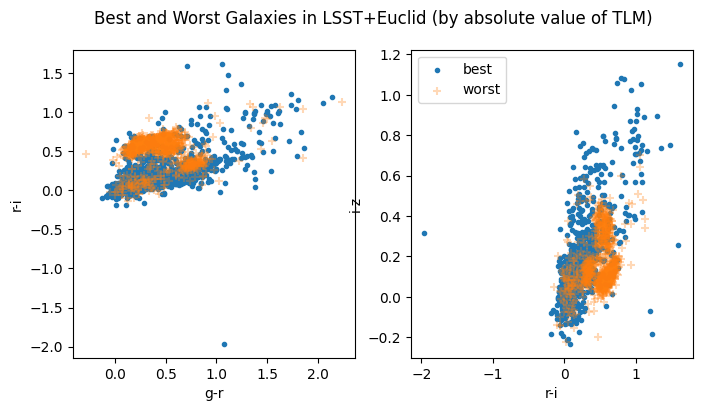

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (8, 4))

i=1

colors_lsst = ['g-r', 'r-i', 'i-z']

plt.suptitle('Best and Worst Galaxies in LSST+Euclid (by absolute value of TLM)')

for color, ax in zip(colors_lsst, ax.reshape(-1)):
  ax.scatter(np.array(catalogs['Euclid+LSST'][color])[best_galaxies_Euclid], np.array(catalogs['Euclid+LSST'][colors_lsst[i]])[best_galaxies_Euclid], label = 'best', marker = '.')
  ax.scatter(np.array(catalogs['Euclid+LSST'][color])[worst_galaxies_Euclid], np.array(catalogs['Euclid+LSST'][colors_lsst[i]])[worst_galaxies_Euclid], label = 'worst', marker = '+', alpha = 0.3)

  ax.set_xlabel(color)
  ax.set_ylabel(colors_lsst[i])

  plt.legend()

  i = i + 1

In [ ]:
from sklearn.datasets import make_blobs

centers = [[1, 1], [-1, -1], [1, -1]]

X, labels_true = make_blobs(
    n_samples=750, centers=centers, cluster_std=0.4, random_state=0
)

In [ ]:
worst_Euclid = np.array([np.array(catalogs['Euclid+LSST']['g-r'])[worst_galaxies_Euclid], np.array(catalogs['Euclid+LSST']['r-i'])[worst_galaxies_Euclid]]).T

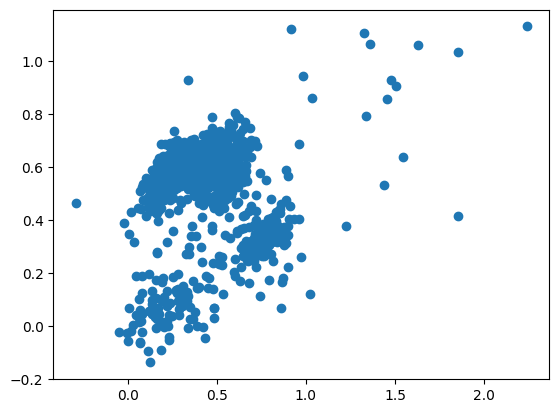

In [ ]:
plt.scatter(worst_Euclid[:,0], worst_Euclid[:,1])

In [ ]:
from sklearn import metrics
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.06, min_samples=10).fit(worst_Euclid)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 3
Estimated number of noise points: 97


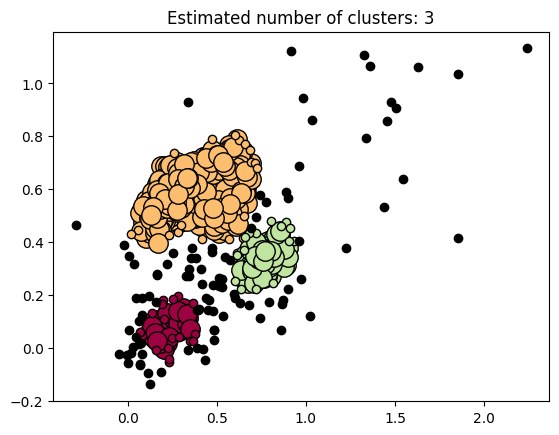

In [ ]:
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = worst_Euclid[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = worst_Euclid[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title(f"Estimated number of clusters: {n_clusters_}")
plt.show()

In [23]:
import seaborn as sns

In [ ]:
delta_tav_array = np.array([np.abs(just_tav['LSST-only'] - just_tav['Euclid+LSST']), catalogs['LSST+CASTOR']['g-r']]).T

(-1.0, 6.0)

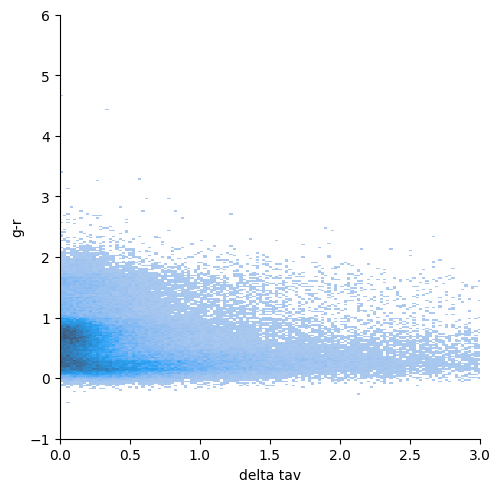

In [ ]:
tav_df_Euclid = pd.DataFrame(delta_tav_array, columns = ['delta tav', 'g-r'])

sns.displot(tav_df_Euclid, x='delta tav', y="g-r")
plt.xlim(0, 3)
plt.ylim(-1, 6)


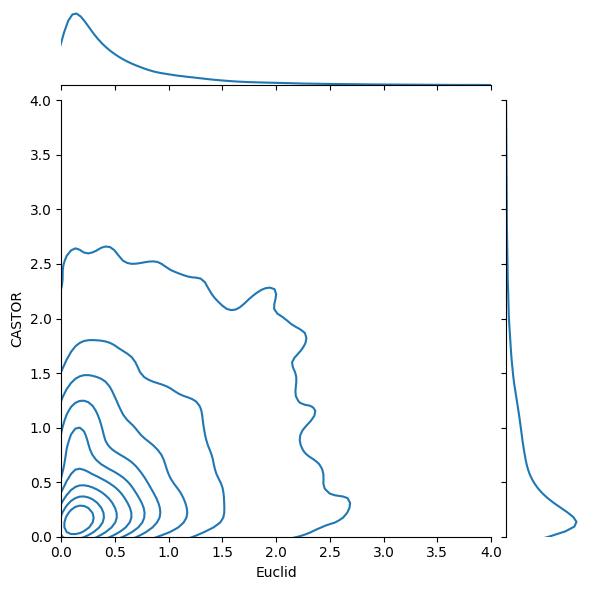

In [ ]:
delta_tav_array = np.array([np.abs(just_tav['Euclid+LSST'] - just_tav['LSST-only']), np.abs(just_tav['LSST+CASTOR'] - just_tav['LSST-only'])]).T

tav_df = pd.DataFrame(delta_tav_array, columns = ['Euclid', 'CASTOR'])

sns.jointplot(data=tav_df.sample(30000), x="Euclid", y="CASTOR",  kind="kde")
plt.xlim(0, 4)
plt.ylim(0, 4)
plt.show()

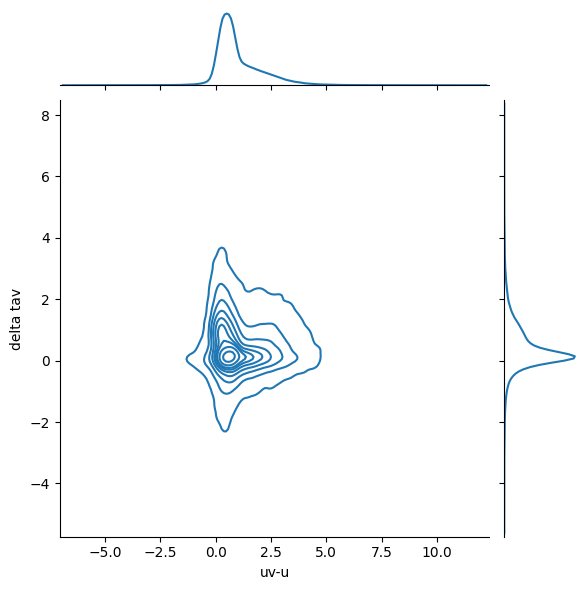

In [ ]:
delta_tav_array = np.array([- just_tav['LSST-only'] + just_tav['LSST+CASTOR'], catalogs['LSST+CASTOR']['uv-u']]).T

tav_df_CASTOR = pd.DataFrame(delta_tav_array, columns = ['delta tav', 'uv-u'])

sns.jointplot(tav_df_Euclid, x='uv-u', y="delta tav", kind = 'kde')
# plt.xlim(0, 3)
# plt.ylim(-1, 6)

(-2.5, 2.5)

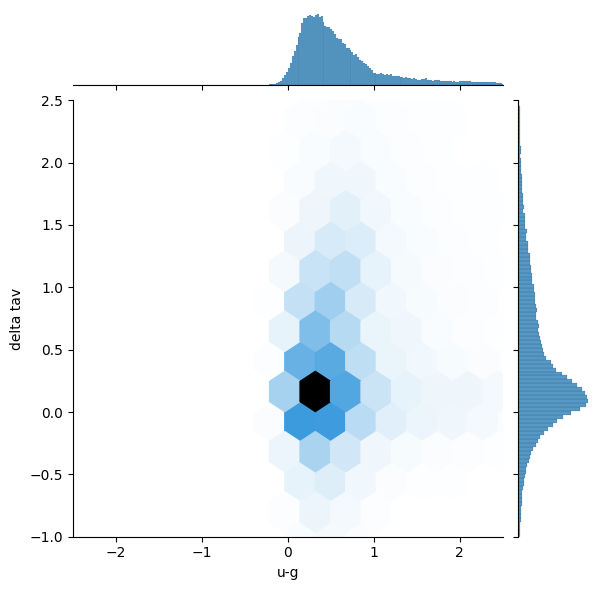

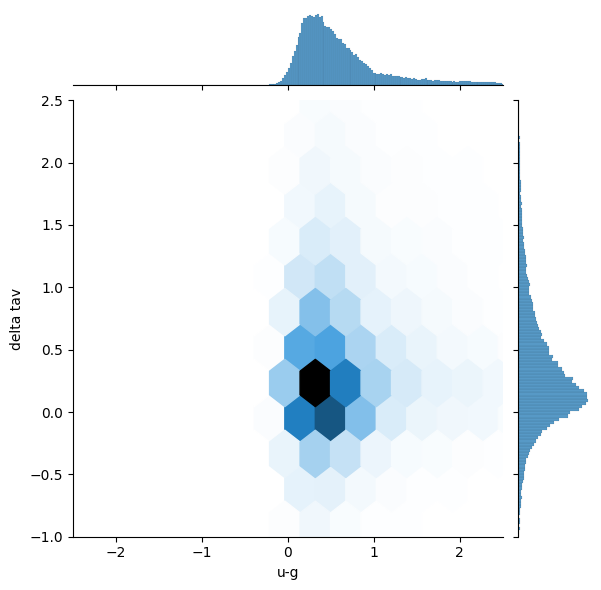

In [ ]:
delta_tav_array = np.array([- just_tav['LSST-only'] + just_tav['LSST+CASTOR'], catalogs['LSST+CASTOR']['u-g']]).T

tav_df_CASTOR = pd.DataFrame(delta_tav_array, columns = ['delta tav', 'u-g'])

delta_tav_array = np.array([- just_tav['LSST-only'] + just_tav['Euclid+LSST'], catalogs['LSST+CASTOR']['u-g']]).T

tav_df_Euclid = pd.DataFrame(delta_tav_array, columns = ['delta tav', 'u-g'])


sns.jointplot(tav_df_CASTOR, x='u-g', y="delta tav", kind = 'hex')
plt.ylim(-1, 2.5)
plt.xlim(-2.5, 2.5)

sns.jointplot(tav_df_Euclid, x='u-g', y="delta tav", kind = 'hex')

plt.ylim(-1, 2.5)
plt.xlim(-2.5, 2.5)

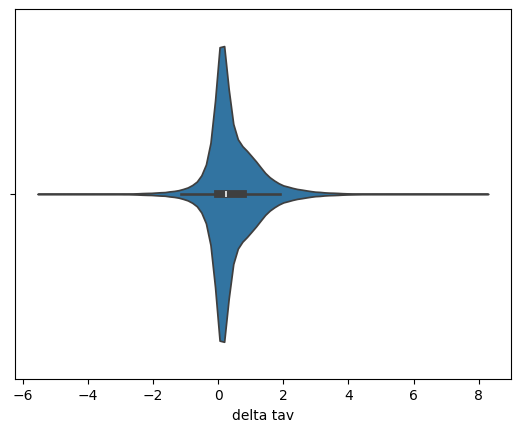

<Axes: xlabel='delta tav'>

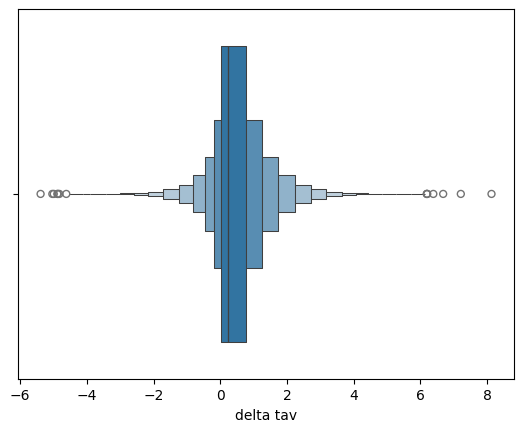

In [ ]:
sns.violinplot(x=tav_df_CASTOR["delta tav"])
plt.show()
sns.boxenplot(x=tav_df_CASTOR["delta tav"])

# sns.boxenplot(x=tav_df_Euclid["delta tav"])

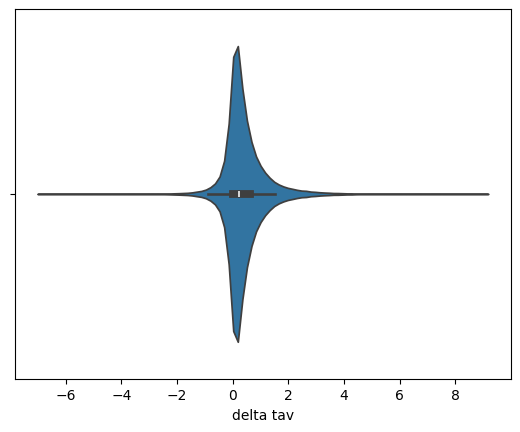

<Axes: xlabel='delta tav'>

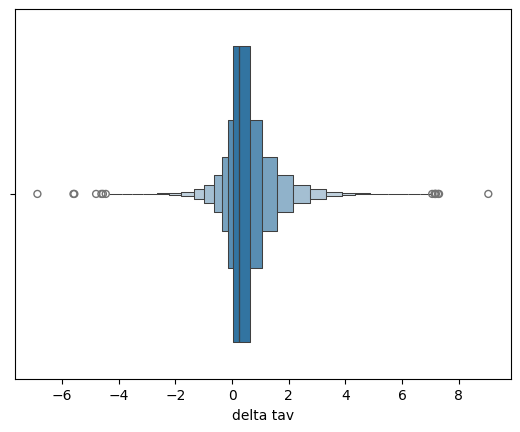

In [ ]:
sns.violinplot(x=tav_df_Euclid["delta tav"])
plt.show()
sns.boxenplot(x=tav_df_Euclid["delta tav"])

In [ ]:
tav_df_CASTOR[tav_df_CASTOR['delta tav']> 2]

,delta tav,u-g
0,2.539986,0.354974
27,2.407852,3.224832
44,2.390154,0.847674
48,2.301506,4.031780
57,2.285096,0.240396
...,...,...
108678,2.417027,1.202415
108723,2.184452,1.482448
108791,2.485794,0.195225
108794,2.209315,3.148022


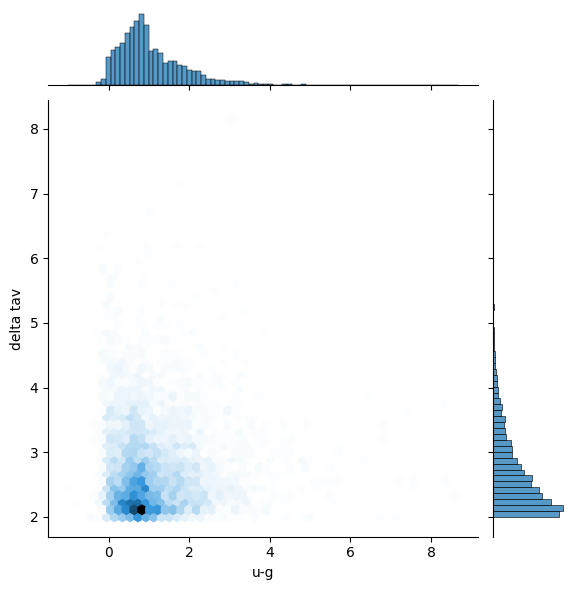

In [ ]:
sns.jointplot(tav_df_CASTOR[tav_df_CASTOR['delta tav']> 2], x='u-g', y="delta tav", kind = 'hex')
# plt.ylim(-1, 2.5)
# plt.xlim(-2.5, 2.5)

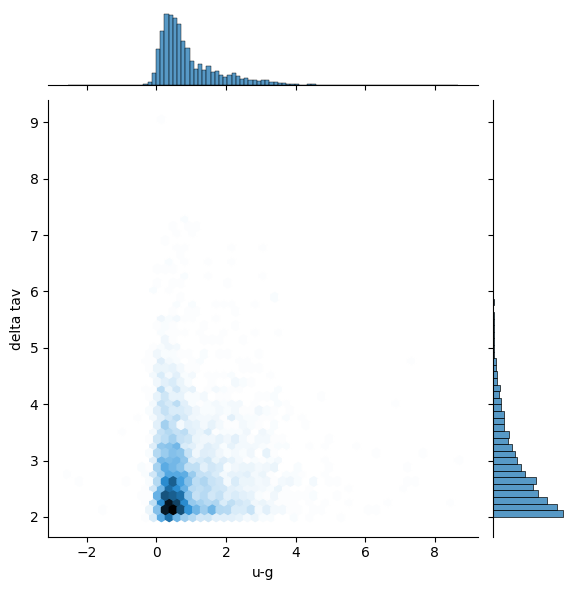

In [ ]:



sns.jointplot(tav_df_Euclid[tav_df_Euclid['delta tav']> 2], x='u-g', y="delta tav", kind = 'hex')


(-1.0, 3.0)

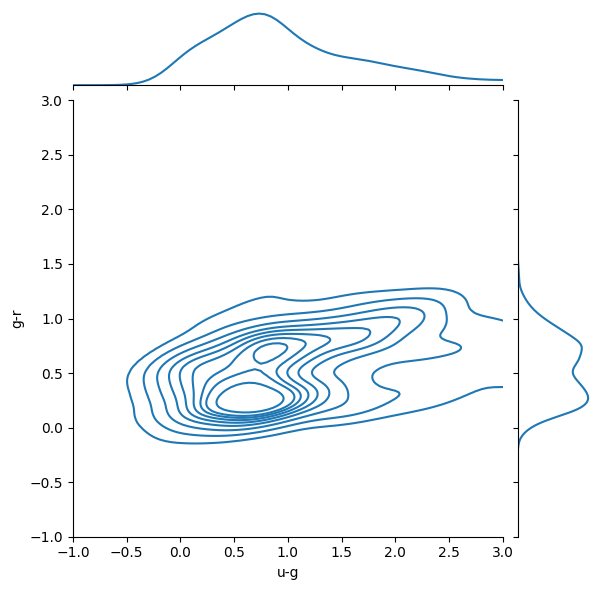

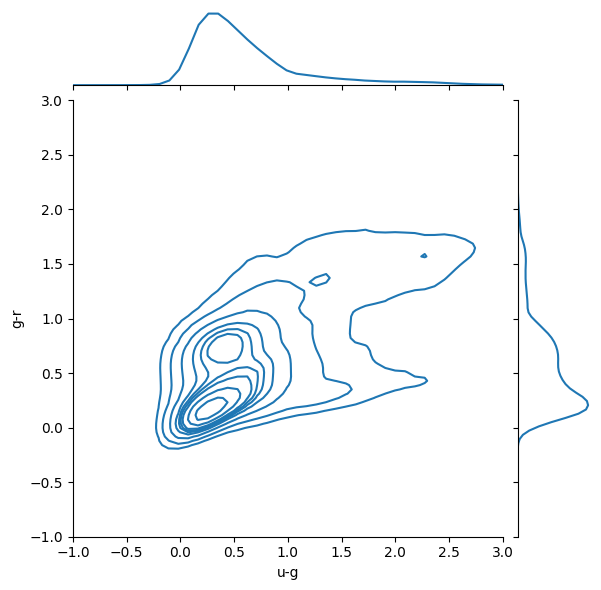

In [ ]:
delta_tav_array = np.array([- just_tav['LSST-only'] + just_tav['LSST+CASTOR'], catalogs['LSST+CASTOR']['u-g'], catalogs['LSST+CASTOR']['g-r'], catalogs['LSST+CASTOR']['z_true']]).T

tav_df_CASTOR = pd.DataFrame(delta_tav_array, columns = ['delta tav', 'u-g', 'g-r', 'z_true'])

sns.jointplot(tav_df_CASTOR[tav_df_CASTOR['delta tav']> 2], x='u-g', y="g-r", kind = 'kde')

plt.ylim(-1, 3)
plt.xlim(-1, 3)

sns.jointplot(tav_df_CASTOR[tav_df_CASTOR['delta tav']< 2], x='u-g', y="g-r", kind = 'kde')

plt.ylim(-1, 3)
plt.xlim(-1, 3)

(-1.5, 5.5)

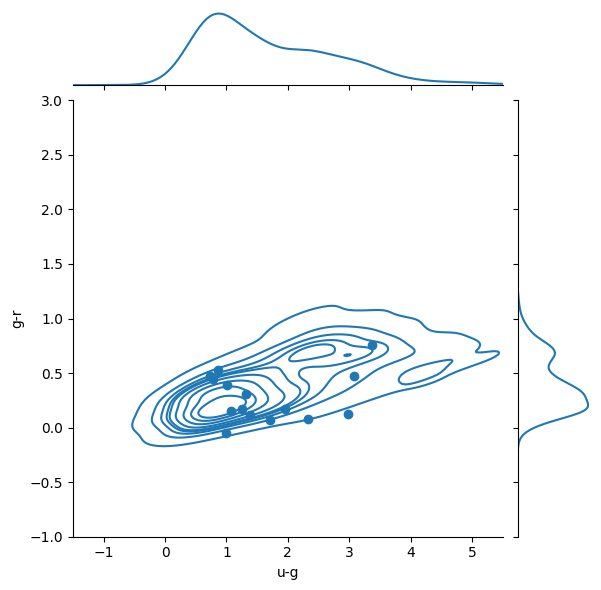

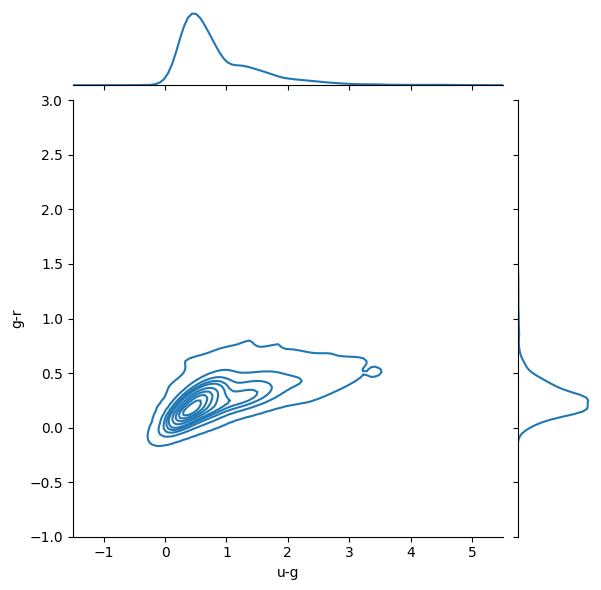

In [78]:
delta_tav_array = np.array([- just_tav['LSST-only'] + just_tav['LSST+CASTOR'], catalogs['LSST+CASTOR']['u-g'], catalogs['LSST+CASTOR']['g-r'], catalogs['LSST+CASTOR']['z_true']]).T

tav_df_CASTOR = pd.DataFrame(delta_tav_array, columns = ['delta tav', 'u-g', 'g-r', 'z_true'])
tav_df_CASTOR_z_cut = tav_df_CASTOR[tav_df_CASTOR['z_true']> 1.5]

sns.jointplot(tav_df_CASTOR_z_cut[tav_df_CASTOR_z_cut['delta tav']> 2], x='u-g', y="g-r", kind = 'kde')

plt.scatter(ug, gr)

plt.ylim(-1, 3)
plt.xlim(-1.5, 5.5)

sns.jointplot(tav_df_CASTOR_z_cut[tav_df_CASTOR_z_cut['delta tav']< 2], x='u-g', y="g-r", kind = 'kde')

plt.ylim(-1, 3)
plt.xlim(-1.5, 5.5)

In [77]:
gr = tav_df_CASTOR_z_cut[tav_df_CASTOR_z_cut['delta tav'] > 2].sort_values(by = ['delta tav'], ascending = False)[0:15]['g-r']
ug = tav_df_CASTOR_z_cut[tav_df_CASTOR_z_cut['delta tav'] > 2].sort_values(by = ['delta tav'], ascending = False)[0:15]['u-g']

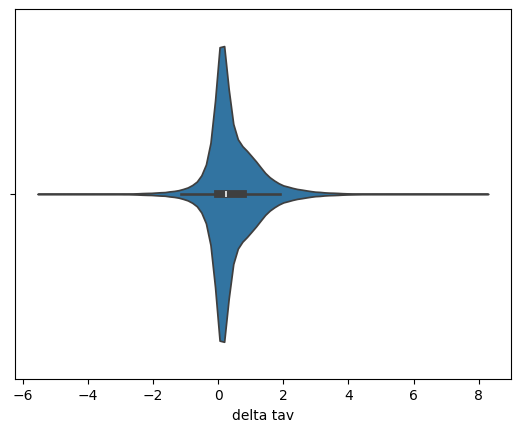

<Axes: xlabel='delta tav'>

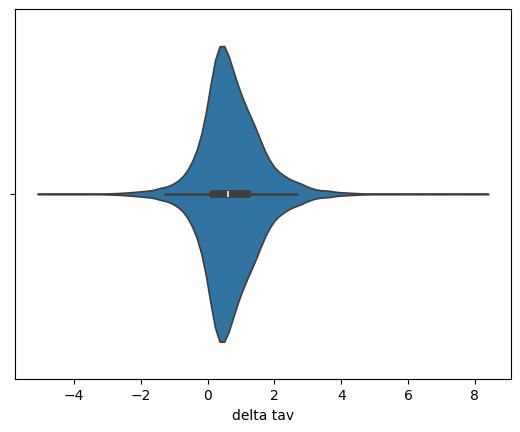

In [35]:
sns.violinplot(x=tav_df_CASTOR["delta tav"])
plt.show()
sns.violinplot(x=tav_df_CASTOR_z_cut["delta tav"])


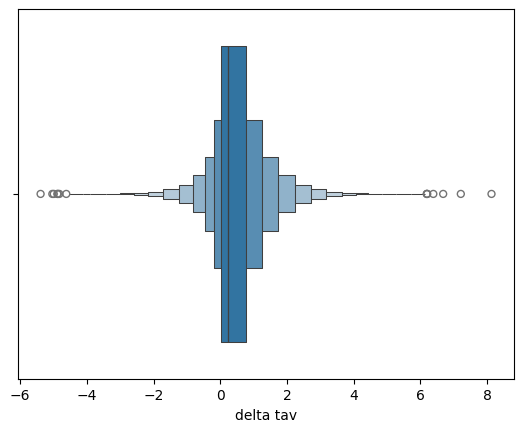

<Axes: xlabel='delta tav'>

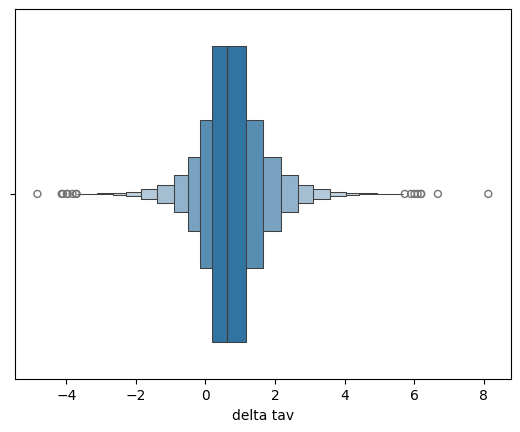

In [36]:
sns.boxenplot(x=tav_df_CASTOR["delta tav"])
plt.show()
sns.boxenplot(x=tav_df_CASTOR_z_cut["delta tav"])

In [22]:
delta_tav_array = np.array([- just_tav['LSST-only'] + just_tav['Euclid+LSST'], catalogs['LSST+CASTOR']['u-g'], catalogs['Euclid+LSST']['g-r']]).T

tav_df_Euclid = pd.DataFrame(delta_tav_array, columns = ['delta tav', 'u-g', 'g-r'])

sns.jointplot(tav_df_Euclid[tav_df_Euclid['delta tav']> 2], x='u-g', y="g-r", kind = 'kde')

plt.ylim(-1, 2.5)
plt.xlim(-1, 3)

sns.jointplot(tav_df_Euclid[tav_df_Euclid['delta tav']< 2], x='u-g', y="g-r", kind = 'kde')

plt.ylim(-1, 2.5)
plt.xlim(-1, 3)

NameError: name 'sns' is not defined

In [ ]:
catalogs['Euclid+LSST'].keys()

Index(['z_true', 'r', 'g-r', 'r-i', 'i-z', 'v', 'v-y', 'y-j', 'j-h'], dtype='object')

(-1.0, 3.0)

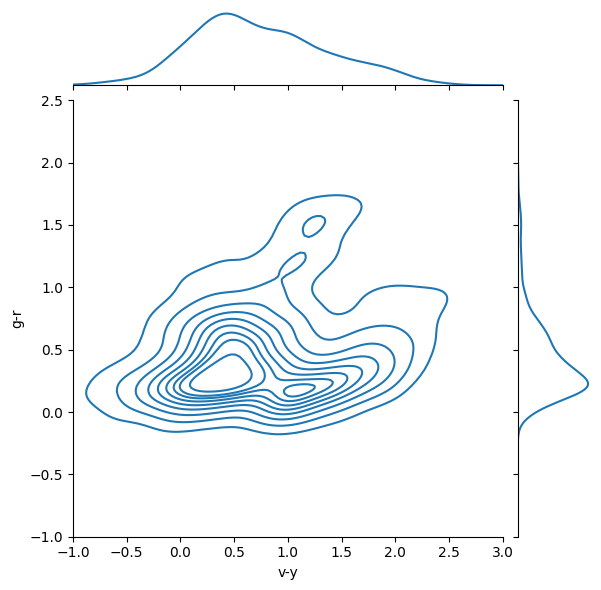

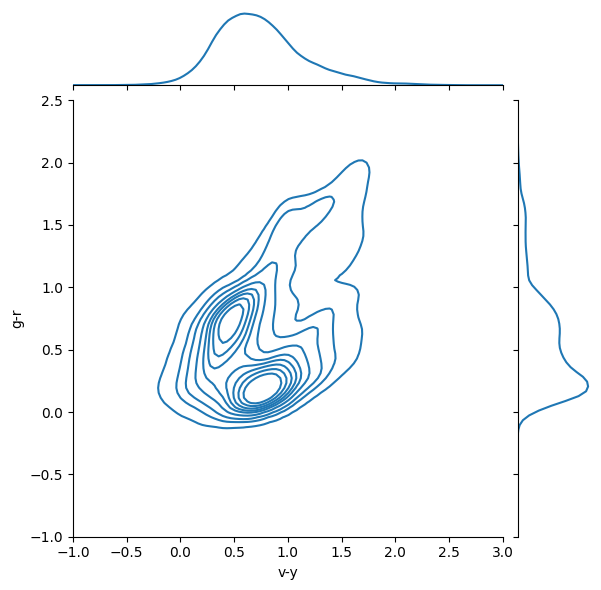

In [ ]:
delta_tav_array = np.array([- just_tav['LSST-only'] + just_tav['Euclid+LSST'], catalogs['Euclid+LSST']['v-y'], catalogs['Euclid+LSST']['g-r']]).T

tav_df_Euclid = pd.DataFrame(delta_tav_array, columns = ['delta tav', 'v-y', 'g-r'])

sns.jointplot(tav_df_Euclid[tav_df_Euclid['delta tav']> 2], x='v-y', y="g-r", kind = 'kde')

plt.ylim(-1, 2.5)
plt.xlim(-1, 3)

sns.jointplot(tav_df_Euclid[tav_df_Euclid['delta tav']< 2], x='v-y', y="g-r", kind = 'kde')

plt.ylim(-1, 2.5)
plt.xlim(-1, 3)

(-1.0, 6.0)

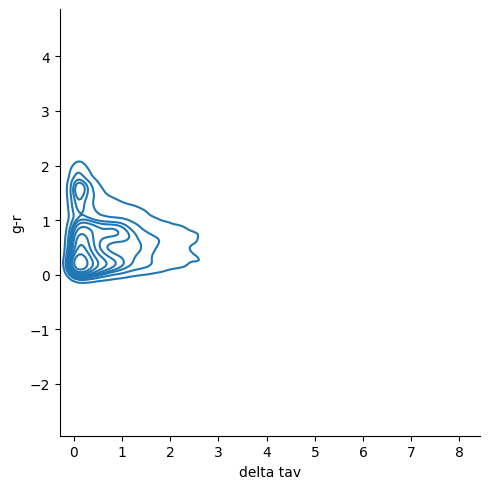

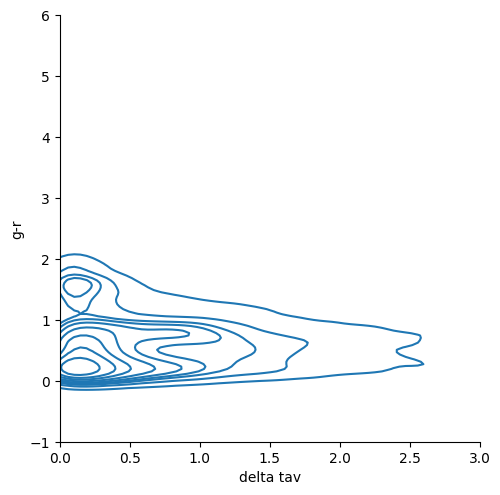

In [ ]:
delta_tav_array = np.array([np.abs(just_tav['LSST-only'] - just_tav['LSST+CASTOR']), catalogs['LSST+CASTOR']['g-r']]).T

tav_df_CASTOR = pd.DataFrame(delta_tav_array, columns = ['delta tav', 'g-r'])

sns.displot(tav_df_Euclid, x='delta tav', y="g-r", kind = 'kde')
sns.displot(tav_df_CASTOR, x='delta tav', y="g-r", kind = 'kde')

plt.xlim(0, 3)
plt.ylim(-1, 6)

In [ ]:
worst_galaxies_Euclid = np.argsort((np.abs(just_tav['Euclid+LSST'])))[::-1][0:1000]
worst_galaxies_CASTOR = np.argsort((np.abs(just_tav['LSST+CASTOR'])))[::-1][0:1000]

best_galaxies_Euclid = np.argsort((np.abs(just_tav['Euclid+LSST'])))[0:1000]
best_galaxies_CASTOR = np.argsort((np.abs(just_tav['LSST+CASTOR'])))[0:1000]

In [ ]:
best_galaxies_Euclid = np.argsort((np.abs(just_tav['Euclid+LSST'])))[0:1000]
best_galaxies_CASTOR = np.argsort((np.abs(just_tav['LSST+CASTOR'])))[0:1000]

In [ ]:
print(np.sum(worst_galaxies_Euclid == worst_galaxies_CASTOR))
print(np.sum(best_galaxies_Euclid == best_galaxies_CASTOR))

# no overlap in the best and worst galaxies in each survey


0
0


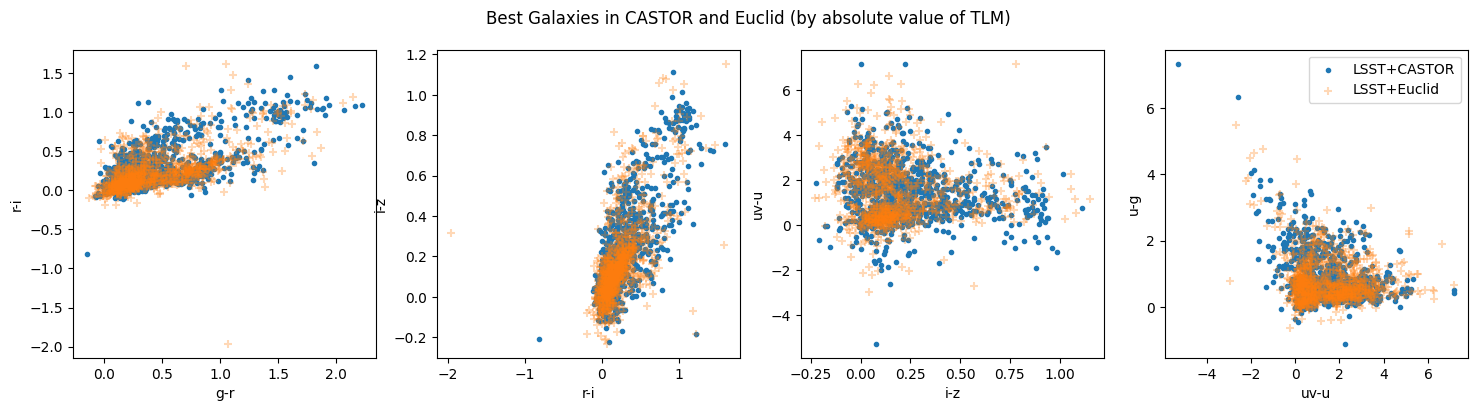

In [ ]:
fig, ax = plt.subplots(1, 4, figsize = (18, 4))

i=1

colors_lsst = ['g-r', 'r-i', 'i-z', 'uv-u', 'u-g']

plt.suptitle('Best Galaxies in CASTOR and Euclid (by absolute value of TLM)')

for color, ax in zip(colors_lsst, ax.reshape(-1)):
  ax.scatter(np.array(catalogs['LSST+CASTOR'][color])[best_galaxies_CASTOR], np.array(catalogs['LSST+CASTOR'][colors_lsst[i]])[best_galaxies_CASTOR], label = 'LSST+CASTOR', marker = '.')
  ax.scatter(np.array(catalogs['LSST+CASTOR'][color])[best_galaxies_Euclid], np.array(catalogs['LSST+CASTOR'][colors_lsst[i]])[best_galaxies_Euclid], label = 'LSST+Euclid', marker = '+', alpha = 0.3)

  ax.set_xlabel(color)
  ax.set_ylabel(colors_lsst[i])

  plt.legend()

  i = i + 1

plt.savefig('theory_group_best_galaxies.png')

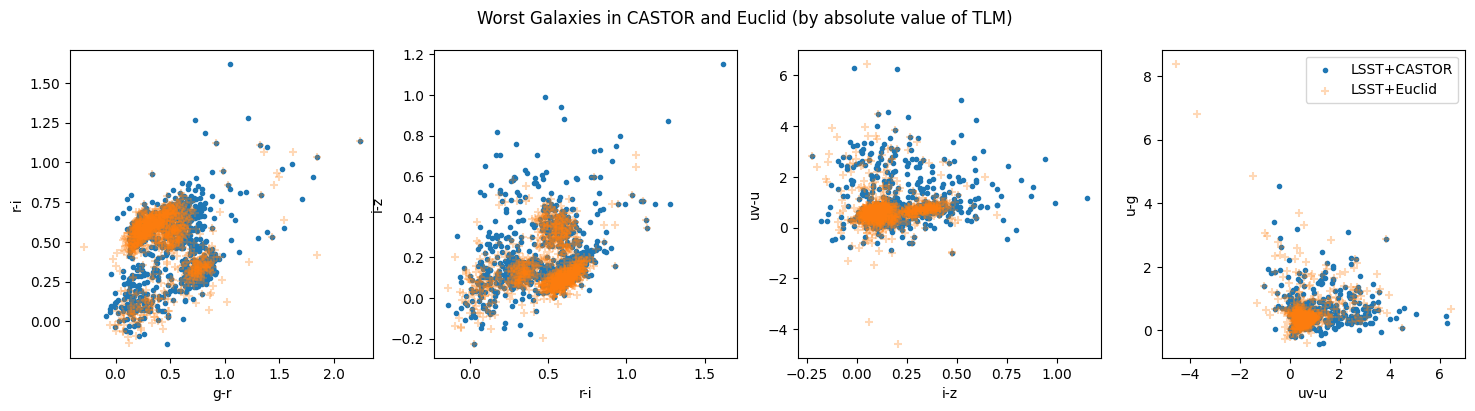

In [ ]:
fig, ax = plt.subplots(1, 4, figsize = (18, 4))

i=1

colors_lsst = ['g-r', 'r-i', 'i-z', 'uv-u', 'u-g']

plt.suptitle('Worst Galaxies in CASTOR and Euclid (by absolute value of TLM)')

for color, ax in zip(colors_lsst, ax.reshape(-1)):
  ax.scatter(np.array(catalogs['LSST+CASTOR'][color])[worst_galaxies_CASTOR], np.array(catalogs['LSST+CASTOR'][colors_lsst[i]])[worst_galaxies_CASTOR], label = 'LSST+CASTOR', marker = '.')
  ax.scatter(np.array(catalogs['LSST+CASTOR'][color])[worst_galaxies_Euclid], np.array(catalogs['LSST+CASTOR'][colors_lsst[i]])[worst_galaxies_Euclid], label = 'LSST+Euclid', marker = '+', alpha = 0.3)

  ax.set_xlabel(color)
  ax.set_ylabel(colors_lsst[i])

  plt.legend()

  i = i + 1

In [ ]:
worst_galaxies = np.argsort((np.abs(just_tav['LSST-only'] - just_tav['LSST+CASTOR'])))[::-1][0:1000]
best_galaxies = np.argsort((np.abs(just_tav['LSST-only'] - just_tav['LSST+CASTOR'])))[0:1000]

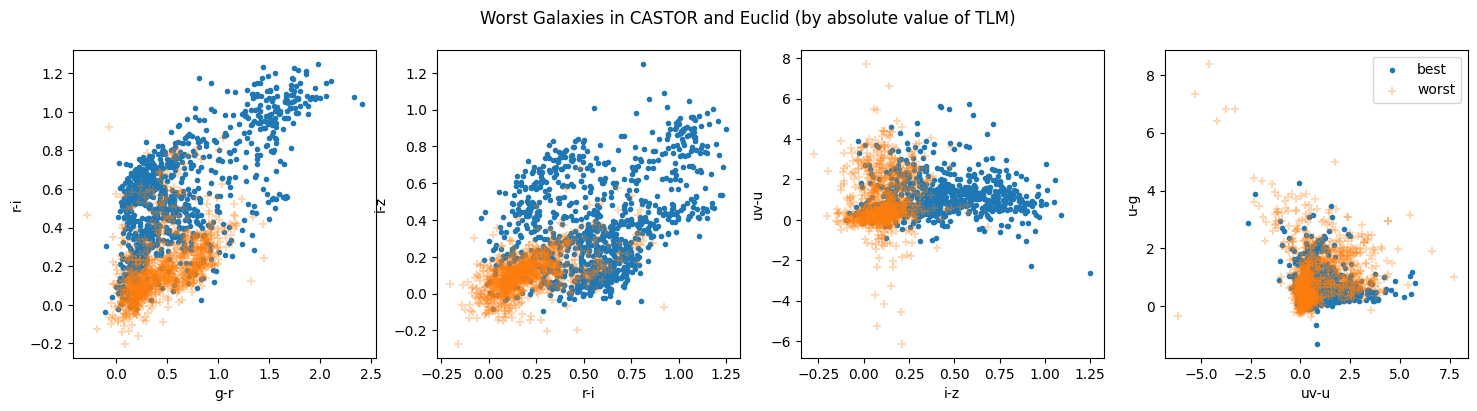

In [ ]:
fig, ax = plt.subplots(1, 4, figsize = (18, 4))

i=1

colors_lsst = ['g-r', 'r-i', 'i-z', 'uv-u', 'u-g']

plt.suptitle('Worst Galaxies in CASTOR and Euclid (by absolute value of TLM)')

for color, ax in zip(colors_lsst, ax.reshape(-1)):
  ax.scatter(np.array(catalogs['LSST+CASTOR'][color])[best_galaxies], np.array(catalogs['LSST+CASTOR'][colors_lsst[i]])[best_galaxies], label = 'best', marker = '.')
  ax.scatter(np.array(catalogs['LSST+CASTOR'][color])[worst_galaxies], np.array(catalogs['LSST+CASTOR'][colors_lsst[i]])[worst_galaxies], label = 'worst', marker = '+', alpha = 0.3)

  ax.set_xlabel(color)
  ax.set_ylabel(colors_lsst[i])

  plt.legend()

  i = i + 1

plt.savefig('placeholder_best_vs_worst.pdf')

In [ ]:
colors

['g-r', 'r-i', 'i-z', 'uv-u', 'u-g', 'v-y', 'y-j', 'j-h']

In [ ]:
from sklearn import manifold

In [ ]:
n_components = 2  # number of coordinates for the manifold

In [ ]:
t_sne = manifold.TSNE(
    n_components=n_components,
    perplexity=30,
    init="random",
    n_iter=250,
    random_state=0,
)

In [ ]:
S_t_sne = t_sne.fit_transform(np.array(catalogs['LSST+CASTOR'].drop(labels = ['z_true', 'TLM_decile'], axis = 1))[best_galaxies])

KeyError: ignored

In [ ]:
x,y = S_t_sne.T

plt.scatter(x, y)

In [ ]:
colors = pd.qcut(flows['LSST+CASTOR'].log_prob(catalogs['LSST+CASTOR'])[best_galaxies], 10, labels = False) #change this to get deciles for the entire catalog and plot corresponding colors

In [ ]:
def plot_2d(points, points_color, title):
    fig, ax = plt.subplots(figsize=(3, 3), facecolor="white", constrained_layout=True)
    fig.suptitle(title, size=16)
    add_2d_scatter(ax, points, points_color)
    plt.show()


def add_2d_scatter(ax, points, points_color, title=None):
    x, y = points.T
    ax.scatter(x, y, c=points_color, s=50, alpha=0.8)
    ax.set_title(title)

In [ ]:
colors = np.array(catalogs['LSST+CASTOR']['TLM_decile'])[best_galaxies]

plot_2d(S_t_sne, colors, 'best galaxies colored by TLM decile')

In [ ]:
colors = pd.qcut(flows['LSST+CASTOR'].log_prob(catalogs['LSST+CASTOR']), 10, labels = False)

In [ ]:
catalogs['LSST+CASTOR']['TLM_decile'] = colors

In [ ]:
catalogs['LSST+CASTOR']

In [ ]:
flows['LSST+CASTOR'].items

In [ ]:
import scipy.stats as sps
n=101
b = sps.mstats.mquantiles(z_true, np.linspace(0,1,n, endpoint=True))
# print(len(z_cats_no_nan[which_os]['z_true']))
# print(b)

b_centers = 0.5*(b[1:] + b[:-1])
db = b[1:] - b[:-1]

In [ ]:
available_os = ['LSST-only',
 'Euclid+LSST',
 'Roman+Euclid+LSST',
 'Roman+Euclid+LSST+CASTOR']

# available_os = ['Euclid+LSST']

In [ ]:
all_tlm = {}
all_milb = {}
all_ent = {}
is_inf_mask = {}

for os in available_os:
    # print(os_names[os])
    # load the photometric catalog for this os
    cat = catalogs[os]

  # Computing the entropy H(z)
    pz = sps.rv_histogram(np.histogram(z_true, bins=b))
    entropy = pz.entropy()
    # just checking that this isn't discrete entropy and that binning doesn't need to match anything else
    # testent = sum(-1 * pz.logpdf(b_centers) * pz.pdf(b_centers) * db)
    # print(entropy - testent)
    all_ent[os] = entropy



  # Computing lower bound
    # all_milb = []
    # print(len(flows[os]))
    # for i in range(10):
    milb = flows[os].log_prob(cat, returnEnsemble=True, err_samples=10)# + entropy
    print(np.sum(np.isinf(milb)))
    print(np.sum(np.isnan(milb)))
    print(np.shape(milb[0,:]))
    # print(milb)
    all_milb[os] = np.array(milb)
    # print(np.shape(all_milb[os]))
    all_tlm[os] = milb.mean(axis=1) + entropy
    is_inf_mask[os] = np.isinf(all_tlm[os])
    all_tlm[os] = all_tlm[os][~np.isinf(all_tlm[os])]
    print(np.sum(np.isinf(all_tlm[os])))

<ipython-input-24-46eeceb1d563>:12: RuntimeWarning: Bin widths are not constant. Assuming `density=True`.Specify `density` explicitly to silence this warning.
  pz = sps.rv_histogram(np.histogram(z_true, bins=b))


0
0
(30,)
0


<ipython-input-24-46eeceb1d563>:12: RuntimeWarning: Bin widths are not constant. Assuming `density=True`.Specify `density` explicitly to silence this warning.
  pz = sps.rv_histogram(np.histogram(z_true, bins=b))


1
0
(30,)
0


<ipython-input-24-46eeceb1d563>:12: RuntimeWarning: Bin widths are not constant. Assuming `density=True`.Specify `density` explicitly to silence this warning.
  pz = sps.rv_histogram(np.histogram(z_true, bins=b))


0
0
(30,)
0


<ipython-input-24-46eeceb1d563>:12: RuntimeWarning: Bin widths are not constant. Assuming `density=True`.Specify `density` explicitly to silence this warning.
  pz = sps.rv_histogram(np.histogram(z_true, bins=b))


0
0
(30,)
0


In [ ]:
print(is_inf_mask['LSST-only'])

[False False False ... False False False]


In [ ]:
# drop nonconverged flows here

zbins = np.linspace(0, 3, 100)
avgtav = {}
errtav = {}
for os in available_os:
  print(os)
  plotran = np.empty_like(zbins)
  ploterr = np.empty_like(zbins)
  print(catalogs[os].columns)
  if 'logprob' not in catalogs[os].columns.values:
    catalogs[os]['logprob'] = all_tlm[os]
    print(catalogs[os].columns)
  for i, zmin in enumerate(zbins[:-1]):
    zmax = zbins[i+1]
    subset = catalogs[os][(catalogs[os]['z_true'] >= zmin) & (catalogs[os]['z_true'] < zmax)]
    # print((zmin, len(subset), zmax))
    vals = subset['logprob']
    mean = np.mean(vals)
    std = np.std(vals)
    plotran[i] = mean
    ploterr[i] = std

  print(len(plotran))
  avgtav[os] = plotran
  errtav[os] = ploterr

LSST-only
Index(['z_true', 'r', 'g-r', 'r-i', 'i-z', 'logprob'], dtype='object')
100
Euclid+LSST
Index(['z_true', 'r', 'g-r', 'r-i', 'i-z', 'v', 'v-y', 'y-j', 'j-h'], dtype='object')


ValueError: ignored

In [ ]:
for os in available_os:
  catalogs[os] = catalogs[os][is_inf_mask[os]]

0
nan


ValueError: ignored

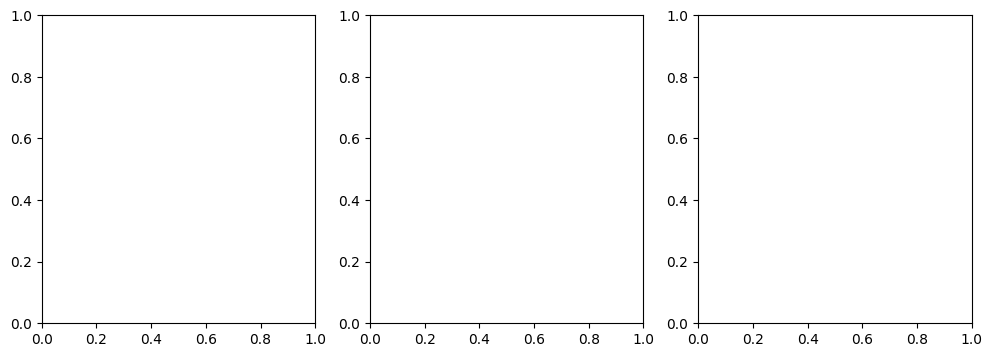

In [ ]:
fig, ax = plt.subplots(1, 3, figsize = (12, 4))

for os in available_os:
  print(np.sum(np.isinf(avgtav[os])))
  print(np.min(avgtav[os]))
  ax[0].plot(zbins, avgtav[os], label=os, alpha=0.5)
  ax[0].fill_between(zbins, avgtav[os] - errtav[os], avgtav[os] + errtav[os], alpha = 0.1)
# plt.ylim(-10, 5)
ax[0].legend(fontsize = 8)
ax[0].set_xlabel('z_true')
ax[0].set_ylabel(chr(0x05ea))
ax[0].set_ylim(-1, 5)
# plt.savefig(prepend+'all_combos_over_z.pdf')


color_lim_min = np.min(catalogs['LSST+CASTOR']['g-r'])
color_lim_max = np.max(catalogs['LSST+CASTOR']['g-r'])

color_bins = np.linspace(color_lim_min, color_lim_max, 10)
avgtav = {}
errtav = {}
for os in available_os:
  print(os)
  color_bins = np.linspace(color_lim_min, color_lim_max, 10)

  plotran = np.empty_like(color_bins)
  ploterr = np.empty_like(color_bins)
  # print(catalogs[os].columns)
  # if 'logprob' not in catalogs[os].columns.values:
  catalogs[os]['logprob'] = all_tlm[os]
  print(np.sum(np.isinf(all_tlm[os]))) #no nans in logprob
  # print(np.sum(np.isnan(plotran)))
    # print(catalogs[os].columns)
  for i, color_min in enumerate(color_bins[:-1]):
    color_max = color_bins[i+1]
    subset = catalogs[os][(catalogs['LSST+CASTOR']['g-r'] >= color_min) & (catalogs['LSST+CASTOR']['g-r'] <= color_max)]
    # print(len(subset))
    # print((color_min, len(subset), color_max))
    vals = subset['logprob']
    # print(np.max(vals))
    # print(len(vals))
    mean = np.mean(vals)
    # print(np.sum(np.isnan(mean)))
    # print(mean)
    std = np.std(vals)
    plotran[i] = mean
    ploterr[i] = std
  avgtav[os] = plotran
  errtav[os] = ploterr


for os in available_os:
  ax[1].plot(color_bins, avgtav[os], label=os, alpha=0.5)
  ax[1].fill_between(color_bins, avgtav[os] - errtav[os], avgtav[os] + errtav[os], alpha = 0.1)
ax[1].legend()
ax[1].set_xlabel('g-r')
ax[1].set_ylabel(chr(0x05ea))
ax[1].set_ylim(-5, 5)
ax[1].set_xlim(-2, 5)


worst_galaxies = np.argsort((np.abs(just_tav['LSST-only'] - just_tav['LSST+CASTOR'])))[::-1][0:1000]
# best_galaxies = np.argsort((np.abs(just_tav['LSST-only'] - just_tav['Euclid+LSST+CASTOR'])))[0:1000]

for os in available_os:
  plt.hist(just_tav[os][worst_galaxies], alpha=0.25, label=os, density=True, bins=np.linspace(-5, 4, 100))
plt.legend()
plt.xlim(-5.2,4)
plt.xlabel(chr(0x05ea))#r'$\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]$')
plt.yticks([])

LSST-only
0
Euclid+LSST
1
Roman+Euclid+LSST
0
Roman+Euclid+LSST+CASTOR
0
LSST-only
0
Euclid+LSST
1
Roman+Euclid+LSST
0
Roman+Euclid+LSST+CASTOR
0
LSST-only
0
Euclid+LSST
1
Roman+Euclid+LSST
0
Roman+Euclid+LSST+CASTOR
0
LSST-only
0
Euclid+LSST
1
Roman+Euclid+LSST
0
Roman+Euclid+LSST+CASTOR
0
LSST-only
0
Euclid+LSST
1
Roman+Euclid+LSST
0
Roman+Euclid+LSST+CASTOR
0
LSST-only
0
Euclid+LSST
1
Roman+Euclid+LSST
0
Roman+Euclid+LSST+CASTOR
0
LSST-only
0
Euclid+LSST
1
Roman+Euclid+LSST
0
Roman+Euclid+LSST+CASTOR
0
LSST-only
0
Euclid+LSST
1
Roman+Euclid+LSST
0
Roman+Euclid+LSST+CASTOR
0


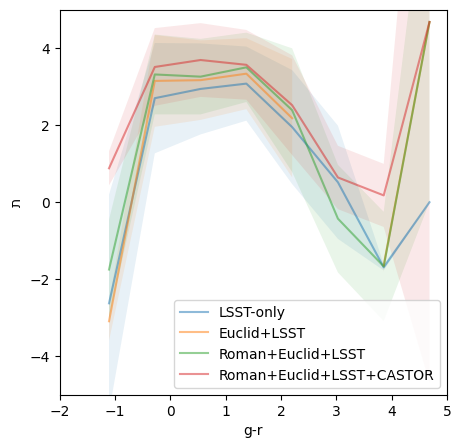

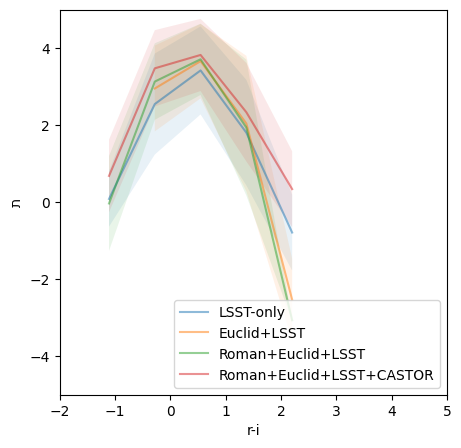

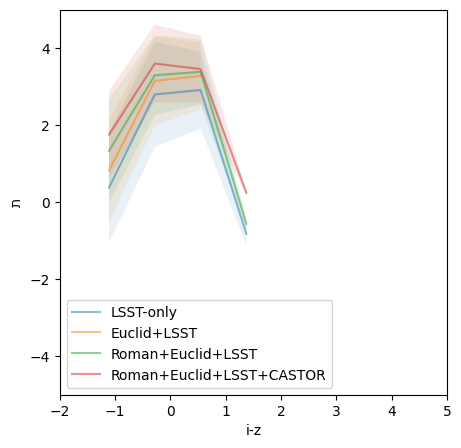

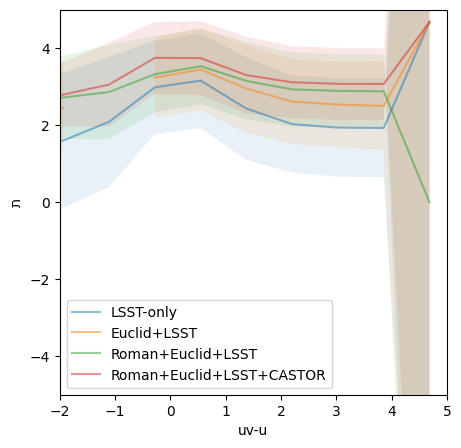

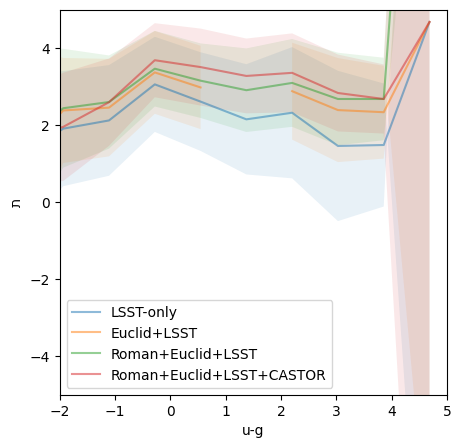

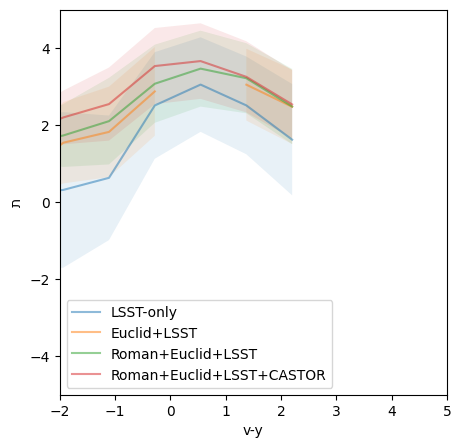

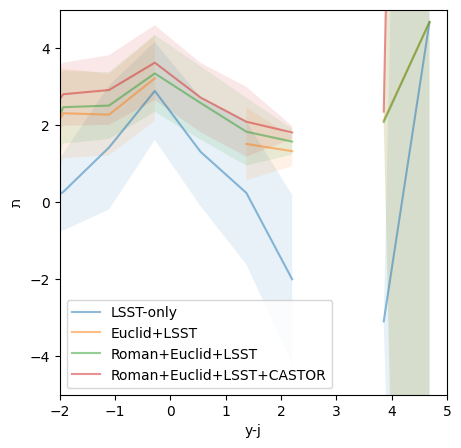

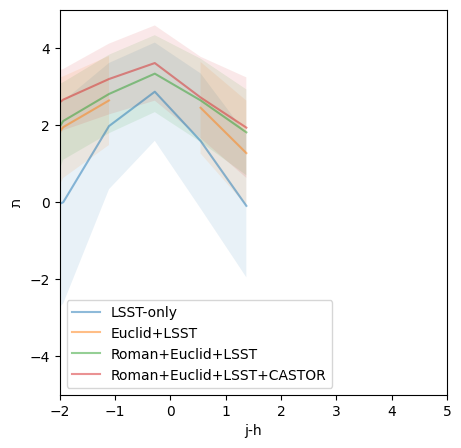

In [ ]:
colors = ['g-r', 'r-i', 'i-z', 'uv-u', 'u-g', 'v-y', 'y-j', 'j-h']

for color in colors:

  fig, ax = plt.subplots(1, 1, figsize = (5, 5))

  for os in available_os:
    print(os)
    color_bins = np.linspace(color_lim_min, color_lim_max, 10)

    plotran = np.empty_like(color_bins)
    ploterr = np.empty_like(color_bins)
  # print(catalogs[os].columns)
  # if 'logprob' not in catalogs[os].columns.values:
    catalogs[os]['logprob'] = all_tlm[os]
    print(np.sum(np.isinf(all_tlm[os]))) #no nans in logprob
  # print(np.sum(np.isnan(plotran)))
    # print(catalogs[os].columns)
    for i, color_min in enumerate(color_bins[:-1]):
      color_max = color_bins[i+1]
      subset = catalogs[os][(catalogs["Roman+Euclid+LSST+CASTOR"][color] >= color_min) & (catalogs["Roman+Euclid+LSST+CASTOR"][color] <= color_max)]
    # print(len(subset))
    # print((color_min, len(subset), color_max))
      vals = subset['logprob']
    # print(np.max(vals))
    # print(len(vals))
      mean = np.mean(vals)
    # print(np.sum(np.isnan(mean)))
    # print(mean)
      std = np.std(vals)
      plotran[i] = mean
      ploterr[i] = std
    avgtav[os] = plotran
    errtav[os] = ploterr

    ax.plot(color_bins, avgtav[os], label=os, alpha=0.5)
    ax.fill_between(color_bins, avgtav[os] - errtav[os], avgtav[os] + errtav[os], alpha = 0.1)
  ax.legend()
  ax.set_xlabel(color)
  ax.set_ylabel(chr(0x05ea))
  ax.set_ylim(-5, 5)
  ax.set_xlim(-2, 5)
plt.show()


LSST-only
1
CASTOR-only
0
Euclid+CASTOR
0
LSST+CASTOR
0


(-1.0, 1.5)

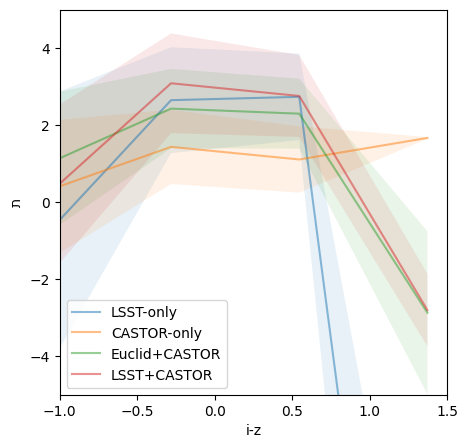

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (5, 5))


for os in available_os:
  print(os)
  color_bins = np.linspace(color_lim_min, color_lim_max, 10)

  plotran = np.empty_like(color_bins)
  ploterr = np.empty_like(color_bins)
  # print(catalogs[os].columns)
  # if 'logprob' not in catalogs[os].columns.values:
  catalogs[os]['logprob'] = all_tlm[os]
  print(np.sum(np.isinf(all_tlm[os]))) #no nans in logprob
  # print(np.sum(np.isnan(plotran)))
    # print(catalogs[os].columns)
  for i, color_min in enumerate(color_bins[:-1]):
    color_max = color_bins[i+1]
    subset = catalogs[os][(catalogs['LSST+CASTOR']['i-z'] >= color_min) & (catalogs['LSST+CASTOR']['i-z'] <= color_max)]
    # print(len(subset))
    # print((color_min, len(subset), color_max))
    vals = subset['logprob']
    # print(np.max(vals))
    # print(len(vals))
    mean = np.mean(vals)
    # print(np.sum(np.isnan(mean)))
    # print(mean)
    std = np.std(vals)
    plotran[i] = mean
    ploterr[i] = std
  avgtav[os] = plotran
  errtav[os] = ploterr


for os in available_os:
  ax.plot(color_bins, avgtav[os], label=os, alpha=0.5)
  ax.fill_between(color_bins, avgtav[os] - errtav[os], avgtav[os] + errtav[os], alpha = 0.1)
ax.legend()
ax.set_xlabel('i-z')
ax.set_ylabel(chr(0x05ea))
ax.set_ylim(-5, 5)
ax.set_xlim(-1, 1.5)

LSST-only
1
CASTOR-only
0
Euclid+CASTOR
0
LSST+CASTOR
0


(-1.0, 1.5)

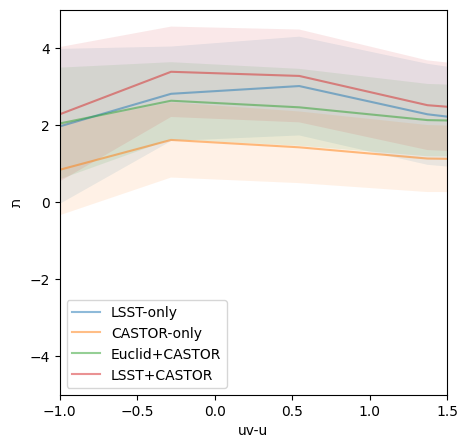

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (5, 5))


for os in available_os:
  print(os)
  color_bins = np.linspace(color_lim_min, color_lim_max, 10)

  plotran = np.empty_like(color_bins)
  ploterr = np.empty_like(color_bins)
  # print(catalogs[os].columns)
  # if 'logprob' not in catalogs[os].columns.values:
  catalogs[os]['logprob'] = all_tlm[os]
  print(np.sum(np.isinf(all_tlm[os]))) #no nans in logprob
  # print(np.sum(np.isnan(plotran)))
    # print(catalogs[os].columns)
  for i, color_min in enumerate(color_bins[:-1]):
    color_max = color_bins[i+1]
    subset = catalogs[os][(catalogs['LSST+CASTOR']['uv-u'] >= color_min) & (catalogs['LSST+CASTOR']['uv-u'] <= color_max)]
    # print(len(subset))
    # print((color_min, len(subset), color_max))
    vals = subset['logprob']
    # print(np.max(vals))
    # print(len(vals))
    mean = np.mean(vals)
    # print(np.sum(np.isnan(mean)))
    # print(mean)
    std = np.std(vals)
    plotran[i] = mean
    ploterr[i] = std
  avgtav[os] = plotran
  errtav[os] = ploterr


for os in available_os:
  ax.plot(color_bins, avgtav[os], label=os, alpha=0.5)
  ax.fill_between(color_bins, avgtav[os] - errtav[os], avgtav[os] + errtav[os], alpha = 0.1)
ax.legend()
ax.set_xlabel('uv-u')
ax.set_ylabel(chr(0x05ea))
ax.set_ylim(-5, 5)
ax.set_xlim(-1, 1.5)

LSST-only
1
CASTOR-only
0
Euclid+CASTOR
0
LSST+CASTOR
0


(-1.0, 1.5)

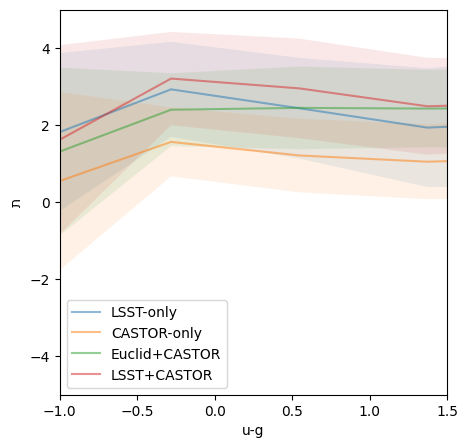

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (5, 5))


for os in available_os:
  print(os)
  color_bins = np.linspace(color_lim_min, color_lim_max, 10)

  plotran = np.empty_like(color_bins)
  ploterr = np.empty_like(color_bins)
  # print(catalogs[os].columns)
  # if 'logprob' not in catalogs[os].columns.values:
  catalogs[os]['logprob'] = all_tlm[os]
  print(np.sum(np.isinf(all_tlm[os]))) #no nans in logprob
  # print(np.sum(np.isnan(plotran)))
    # print(catalogs[os].columns)
  for i, color_min in enumerate(color_bins[:-1]):
    color_max = color_bins[i+1]
    subset = catalogs[os][(catalogs['LSST+CASTOR']['u-g'] >= color_min) & (catalogs['LSST+CASTOR']['u-g'] <= color_max)]
    # print(len(subset))
    # print((color_min, len(subset), color_max))
    vals = subset['logprob']
    # print(np.max(vals))
    # print(len(vals))
    mean = np.mean(vals)
    # print(np.sum(np.isnan(mean)))
    # print(mean)
    std = np.std(vals)
    plotran[i] = mean
    ploterr[i] = std
  avgtav[os] = plotran
  errtav[os] = ploterr


for os in available_os:
  ax.plot(color_bins, avgtav[os], label=os, alpha=0.5)
  ax.fill_between(color_bins, avgtav[os] - errtav[os], avgtav[os] + errtav[os], alpha = 0.1)
ax.legend()
ax.set_xlabel('u-g')
ax.set_ylabel(chr(0x05ea))
ax.set_ylim(-5, 5)
ax.set_xlim(-1, 1.5)

In [ ]:
catalogs['LSST+CASTOR']

,z_true,r,g-r,r-i,i-z,uv-u,u-g,TLM_decile,logprob
CASTOR_ID,,,,,,,,,
3,0.2211,23.259175,0.233539,0.022705,-0.005428,-0.081215,0.354974,7,3.981258
12,0.7070,24.580852,0.256711,0.638455,0.055040,0.274217,0.072682,0,1.105734
73,0.4290,22.664345,0.849034,0.207854,0.116569,0.540868,0.443804,3,2.688282
74,1.5087,23.744620,0.068058,0.050240,-0.009388,1.503954,0.277857,3,2.688986
85,1.0800,24.119466,0.139313,0.230962,0.423380,0.846885,0.173584,5,3.480589
...,...,...,...,...,...,...,...,...,...
964424,0.3275,20.315891,1.310021,0.486272,0.266220,-0.169152,2.147752,4,3.077720
964426,0.3230,23.775628,0.738462,0.247866,0.226397,0.701451,0.693045,6,3.628557
964427,1.4726,25.507346,2.642820,2.072411,0.918244,-0.684684,2.263595,0,-1.256718


In [ ]:
test_tav = {}
for os in available_os:
  test_tav[os] = flows[os].log_prob(catalogs[os], returnEnsemble = True)

In [ ]:
for os in available_os:
  print(np.sum(pd.DataFrame(np.isnan(test_tav[os]))))

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
dtype: int64
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
dtype: int64
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
dtype: int64
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
d

Dropping bad flows below

In [ ]:
comparison_os = available_os + comparison_os

In [ ]:
losses = {}
for os in available_os:
  with (open(f"losses_for_{os}.pkl", 'rb')) as openfile:
    losses[os] = pd.read_pickle(openfile)

In [ ]:
flow_list = list(np.linspace(0, 29, 30).astype(int))
bad_flows = {}

for os in available_os:
  bad_flows_list = []
  for flow in flow_list:
    if np.sum(np.isinf(np.array(losses[os]['losses'][f"Flow {flow}"]))) > 0:
      bad_flows_list.append(flow)
    bad_flows[os] = bad_flows_list

In [ ]:
bad_flows

{'LSST-only': [8, 17, 20],
 'Euclid+LSST': [2, 8, 9, 13],
 'Roman+Euclid+LSST': [2, 5, 14, 16, 19],
 'Roman+Euclid+LSST+CASTOR': [7, 15]}

In [ ]:
just_tav_ensemble = {}
for os in available_os:
  just_tav_ensemble[os] = flows[os].log_prob(catalogs[os], returnEnsemble = True)

In [ ]:
new_tav = {}

for os in available_os:
  new_tav[os] = np.delete(just_tav_ensemble[os], bad_flows[os], axis = 1)

In [ ]:
for os in available_os:
  print(new_tav[os].shape)

(108838, 27)
(108838, 26)
(108838, 25)
(108838, 28)


In [ ]:
all_tlm = {}
all_milb = {}
all_ent = {}
is_inf_mask = {}

for os in available_os:
    # print(os_names[os])
    # load the photometric catalog for this os
    cat = catalogs[os]

  # Computing the entropy H(z)
    pz = sps.rv_histogram(np.histogram(z_true, bins=b))
    entropy = pz.entropy()
    # just checking that this isn't discrete entropy and that binning doesn't need to match anything else
    # testent = sum(-1 * pz.logpdf(b_centers) * pz.pdf(b_centers) * db)
    # print(entropy - testent)
    all_ent[os] = entropy



  # Computing lower bound
    # all_milb = []
    # print(len(flows[os]))
    # for i in range(10):
    milb = new_tav[os]
    print(np.sum(np.isinf(milb)))
    print(np.sum(np.isnan(milb)))
    print(np.shape(milb[0,:]))
    # print(milb)
    all_milb[os] = np.array(milb)
    # print(np.shape(all_milb[os]))
    all_tlm[os] = milb.mean(axis=1) + entropy
    is_inf_mask[os] = np.isinf(all_tlm[os])
    all_tlm[os] = all_tlm[os][~np.isinf(all_tlm[os])]
    print(np.sum(np.isinf(all_tlm[os])))

0
0
(27,)
0
0
0
(26,)
0
0
0
(25,)
0
0
0
(28,)
0


<ipython-input-30-904673a40063>:12: RuntimeWarning: Bin widths are not constant. Assuming `density=True`.Specify `density` explicitly to silence this warning.
  pz = sps.rv_histogram(np.histogram(z_true, bins=b))


In [ ]:
zbins = np.linspace(0, 3, 100)
avgtav = {}
errtav = {}
for os in available_os:
  print(os)
  plotran = np.empty_like(zbins)
  ploterr = np.empty_like(zbins)
  print(catalogs[os].columns)
  if 'logprob' not in catalogs[os].columns.values:
    catalogs[os]['logprob'] = all_tlm[os]
    print(catalogs[os].columns)
  for i, zmin in enumerate(zbins[:-1]):
    zmax = zbins[i+1]
    subset = catalogs[os][(catalogs[os]['z_true'] >= zmin) & (catalogs[os]['z_true'] < zmax)]
    # print((zmin, len(subset), zmax))
    vals = subset['logprob']
    mean = np.mean(vals)
    std = np.std(vals)
    plotran[i] = mean
    ploterr[i] = std

  print(len(plotran))
  avgtav[os] = plotran
  errtav[os] = ploterr

LSST-only
Index(['z_true', 'r', 'g-r', 'r-i', 'i-z'], dtype='object')
Index(['z_true', 'r', 'g-r', 'r-i', 'i-z', 'logprob'], dtype='object')
100
Euclid+LSST
Index(['z_true', 'r', 'g-r', 'r-i', 'i-z', 'v', 'v-y', 'y-j', 'j-h'], dtype='object')
Index(['z_true', 'r', 'g-r', 'r-i', 'i-z', 'v', 'v-y', 'y-j', 'j-h',
       'logprob'],
      dtype='object')
100
Roman+Euclid+LSST
Index(['z_true', 'r', 'g-r', 'r-i', 'i-z', 'v', 'v-y', 'y-j', 'j-h', '106',
       '129 - 106', '158-129', '184-158'],
      dtype='object')
Index(['z_true', 'r', 'g-r', 'r-i', 'i-z', 'v', 'v-y', 'y-j', 'j-h', '106',
       '129 - 106', '158-129', '184-158', 'logprob'],
      dtype='object')
100
Roman+Euclid+LSST+CASTOR
Index(['z_true', 'r', 'g-r', 'r-i', 'i-z', 'v', 'v-y', 'y-j', 'j-h', 'g',
       'uv-u', 'u-g', '106', '129 - 106', '158-129', '184-158'],
      dtype='object')
Index(['z_true', 'r', 'g-r', 'r-i', 'i-z', 'v', 'v-y', 'y-j', 'j-h', 'g',
       'uv-u', 'u-g', '106', '129 - 106', '158-129', '184-158', 'log

0
-0.7594139161166054
0
4.735076e-318
0
4.735076e-318
0
4.735076e-318
LSST-only
0
Euclid+LSST
0
Roman+Euclid+LSST
0
Roman+Euclid+LSST+CASTOR
0


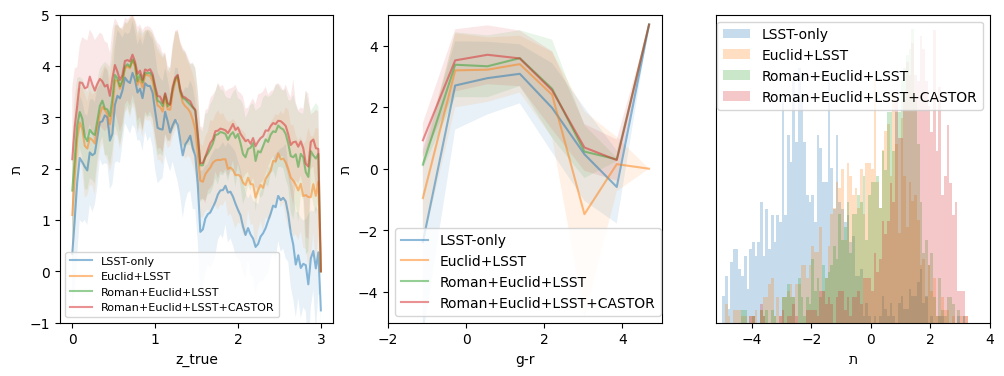

In [ ]:
fig, ax = plt.subplots(1, 3, figsize = (12, 4))

for os in available_os:
  print(np.sum(np.isinf(avgtav[os])))
  print(np.min(avgtav[os]))
  ax[0].plot(zbins, avgtav[os], label=os, alpha=0.5)
  ax[0].fill_between(zbins, avgtav[os] - errtav[os], avgtav[os] + errtav[os], alpha = 0.1)
# plt.ylim(-10, 5)
ax[0].legend(fontsize = 8)
ax[0].set_xlabel('z_true')
ax[0].set_ylabel(chr(0x05ea))
ax[0].set_ylim(-1, 5)
# plt.savefig(prepend+'all_combos_over_z.pdf')


color_lim_min = np.min(catalogs['LSST+CASTOR']['g-r'])
color_lim_max = np.max(catalogs['LSST+CASTOR']['g-r'])

color_bins = np.linspace(color_lim_min, color_lim_max, 10)
avgtav = {}
errtav = {}
for os in available_os:
  print(os)
  color_bins = np.linspace(color_lim_min, color_lim_max, 10)

  plotran = np.empty_like(color_bins)
  ploterr = np.empty_like(color_bins)
  # print(catalogs[os].columns)
  # if 'logprob' not in catalogs[os].columns.values:
  catalogs[os]['logprob'] = all_tlm[os]
  print(np.sum(np.isinf(all_tlm[os]))) #no nans in logprob
  # print(np.sum(np.isnan(plotran)))
    # print(catalogs[os].columns)
  for i, color_min in enumerate(color_bins[:-1]):
    color_max = color_bins[i+1]
    subset = catalogs[os][(catalogs['LSST+CASTOR']['g-r'] >= color_min) & (catalogs['LSST+CASTOR']['g-r'] <= color_max)]
    # print(len(subset))
    # print((color_min, len(subset), color_max))
    vals = subset['logprob']
    # print(np.max(vals))
    # print(len(vals))
    mean = np.mean(vals)
    # print(np.sum(np.isnan(mean)))
    # print(mean)
    std = np.std(vals)
    plotran[i] = mean
    ploterr[i] = std
  avgtav[os] = plotran
  errtav[os] = ploterr


for os in available_os:
  ax[1].plot(color_bins, avgtav[os], label=os, alpha=0.5)
  ax[1].fill_between(color_bins, avgtav[os] - errtav[os], avgtav[os] + errtav[os], alpha = 0.1)
ax[1].legend()
ax[1].set_xlabel('g-r')
ax[1].set_ylabel(chr(0x05ea))
ax[1].set_ylim(-5, 5)
ax[1].set_xlim(-2, 5)


worst_galaxies = np.argsort((np.abs(just_tav['LSST-only'] - just_tav['LSST+CASTOR'])))[::-1][0:1000]
# best_galaxies = np.argsort((np.abs(just_tav['LSST-only'] - just_tav['Euclid+LSST+CASTOR'])))[0:1000]

for os in available_os:
  plt.hist(just_tav[os][worst_galaxies], alpha=0.25, label=os, density=True, bins=np.linspace(-5, 4, 100))
plt.legend()
plt.xlim(-5.2,4)
plt.xlabel(chr(0x05ea))#r'$\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]$')
plt.yticks([])

plt.savefig('new_main_fig.pdf')

<ipython-input-42-c1759df91e94>:40: RuntimeWarning: Bin widths are not constant. Assuming `density=True`.Specify `density` explicitly to silence this warning.
  pz = sps.rv_histogram(np.histogram(z_true, bins=b))


0
0
(28,)
0
0
0
(26,)
0
LSST+CASTOR
Index(['z_true', 'r', 'g-r', 'r-i', 'i-z', 'uv-u', 'u-g'], dtype='object')
Index(['z_true', 'r', 'g-r', 'r-i', 'i-z', 'uv-u', 'u-g', 'logprob'], dtype='object')
100
Euclid+LSST
Index(['z_true', 'r', 'g-r', 'r-i', 'i-z', 'v', 'v-y', 'y-j', 'j-h',
       'logprob'],
      dtype='object')
100
0
-0.7594139161166054
0
4.735076e-318
LSST+CASTOR
0
Euclid+LSST
0


([], [])

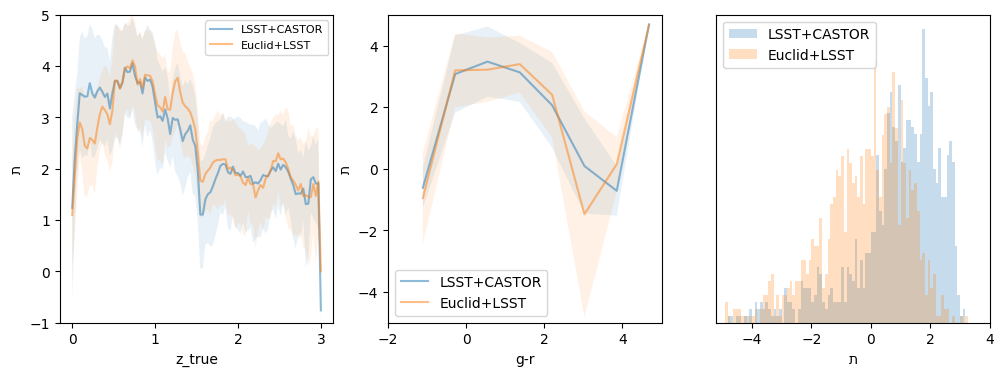

In [ ]:
comparison_os = ['LSST+CASTOR',
                 'Euclid+LSST']


losses = {}
for os in comparison_os:
  with (open(f"losses_for_{os}.pkl", 'rb')) as openfile:
    losses[os] = pd.read_pickle(openfile)

flow_list = list(np.linspace(0, 29, 30).astype(int))
bad_flows = {}

for os in comparison_os:
  bad_flows_list = []
  for flow in flow_list:
    if np.sum(np.isinf(np.array(losses[os]['losses'][f"Flow {flow}"]))) > 0:
      bad_flows_list.append(flow)
    bad_flows[os] = bad_flows_list

just_tav_ensemble = {}
for os in comparison_os:
  just_tav_ensemble[os] = flows[os].log_prob(catalogs[os], returnEnsemble = True)

new_tav = {}

for os in comparison_os:
  new_tav[os] = np.delete(just_tav_ensemble[os], bad_flows[os], axis = 1)

all_tlm = {}
all_milb = {}
all_ent = {}
is_inf_mask = {}

for os in comparison_os:
    # print(os_names[os])
    # load the photometric catalog for this os
    cat = catalogs[os]

  # Computing the entropy H(z)
    pz = sps.rv_histogram(np.histogram(z_true, bins=b))
    entropy = pz.entropy()
    # just checking that this isn't discrete entropy and that binning doesn't need to match anything else
    # testent = sum(-1 * pz.logpdf(b_centers) * pz.pdf(b_centers) * db)
    # print(entropy - testent)
    all_ent[os] = entropy



  # Computing lower bound
    # all_milb = []
    # print(len(flows[os]))
    # for i in range(10):
    milb = new_tav[os]
    print(np.sum(np.isinf(milb)))
    print(np.sum(np.isnan(milb)))
    print(np.shape(milb[0,:]))
    # print(milb)
    all_milb[os] = np.array(milb)
    # print(np.shape(all_milb[os]))
    all_tlm[os] = milb.mean(axis=1) + entropy
    is_inf_mask[os] = np.isinf(all_tlm[os])
    all_tlm[os] = all_tlm[os][~np.isinf(all_tlm[os])]
    print(np.sum(np.isinf(all_tlm[os])))

zbins = np.linspace(0, 3, 100)
avgtav = {}
errtav = {}
for os in comparison_os:
  print(os)
  plotran = np.empty_like(zbins)
  ploterr = np.empty_like(zbins)
  print(catalogs[os].columns)
  if 'logprob' not in catalogs[os].columns.values:
    catalogs[os]['logprob'] = all_tlm[os]
    print(catalogs[os].columns)
  for i, zmin in enumerate(zbins[:-1]):
    zmax = zbins[i+1]
    subset = catalogs[os][(catalogs[os]['z_true'] >= zmin) & (catalogs[os]['z_true'] < zmax)]
    # print((zmin, len(subset), zmax))
    vals = subset['logprob']
    mean = np.mean(vals)
    std = np.std(vals)
    plotran[i] = mean
    ploterr[i] = std

  print(len(plotran))
  avgtav[os] = plotran
  errtav[os] = ploterr

fig, ax = plt.subplots(1, 3, figsize = (12, 4))

for os in comparison_os:
  print(np.sum(np.isinf(avgtav[os])))
  print(np.min(avgtav[os]))
  ax[0].plot(zbins, avgtav[os], label=os, alpha=0.5)
  ax[0].fill_between(zbins, avgtav[os] - errtav[os], avgtav[os] + errtav[os], alpha = 0.1)
# plt.ylim(-10, 5)
ax[0].legend(fontsize = 8)
ax[0].set_xlabel('z_true')
ax[0].set_ylabel(chr(0x05ea))
ax[0].set_ylim(-1, 5)
# plt.savefig(prepend+'all_combos_over_z.pdf')


color_lim_min = np.min(catalogs['LSST+CASTOR']['g-r'])
color_lim_max = np.max(catalogs['LSST+CASTOR']['g-r'])

color_bins = np.linspace(color_lim_min, color_lim_max, 10)
avgtav = {}
errtav = {}
for os in comparison_os:
  print(os)
  color_bins = np.linspace(color_lim_min, color_lim_max, 10)

  plotran = np.empty_like(color_bins)
  ploterr = np.empty_like(color_bins)
  # print(catalogs[os].columns)
  # if 'logprob' not in catalogs[os].columns.values:
  catalogs[os]['logprob'] = all_tlm[os]
  print(np.sum(np.isinf(all_tlm[os]))) #no nans in logprob
  # print(np.sum(np.isnan(plotran)))
    # print(catalogs[os].columns)
  for i, color_min in enumerate(color_bins[:-1]):
    color_max = color_bins[i+1]
    subset = catalogs[os][(catalogs['LSST+CASTOR']['g-r'] >= color_min) & (catalogs['LSST+CASTOR']['g-r'] <= color_max)]
    # print(len(subset))
    # print((color_min, len(subset), color_max))
    vals = subset['logprob']
    # print(np.max(vals))
    # print(len(vals))
    mean = np.mean(vals)
    # print(np.sum(np.isnan(mean)))
    # print(mean)
    std = np.std(vals)
    plotran[i] = mean
    ploterr[i] = std
  avgtav[os] = plotran
  errtav[os] = ploterr


for os in comparison_os:
  ax[1].plot(color_bins, avgtav[os], label=os, alpha=0.5)
  ax[1].fill_between(color_bins, avgtav[os] - errtav[os], avgtav[os] + errtav[os], alpha = 0.1)
ax[1].legend()
ax[1].set_xlabel('g-r')
ax[1].set_ylabel(chr(0x05ea))
ax[1].set_ylim(-5, 5)
ax[1].set_xlim(-2, 5)


worst_galaxies = np.argsort((np.abs(just_tav['LSST-only'] - just_tav['LSST+CASTOR'])))[::-1][0:1000]
# best_galaxies = np.argsort((np.abs(just_tav['LSST-only'] - just_tav['Euclid+LSST+CASTOR'])))[0:1000]

for os in comparison_os:
  plt.hist(just_tav[os][worst_galaxies], alpha=0.25, label=os, density=True, bins=np.linspace(-5, 4, 100))
plt.legend()
plt.xlim(-5.2,4)
plt.xlabel(chr(0x05ea))#r'$\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]$')
plt.yticks([])

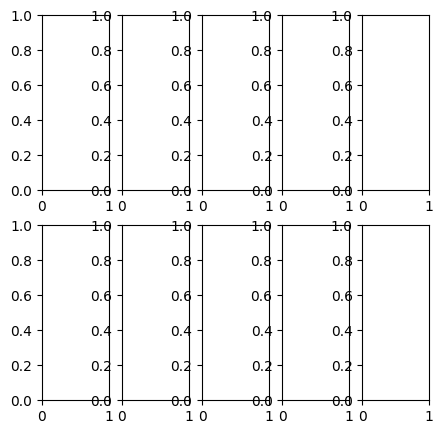

In [ ]:
  fig, ax = plt.subplots(2, 5, figsize = (5, 5))


In [ ]:
for val in zip(colors, ax.reshape(-1)):
  print(np.array(val))

['g-r' <Axes: >]
['r-i' <Axes: >]
['i-z' <Axes: >]
['uv-u' <Axes: >]
['u-g' <Axes: >]
['v-y' <Axes: >]
['y-j' <Axes: >]
['j-h' <Axes: >]


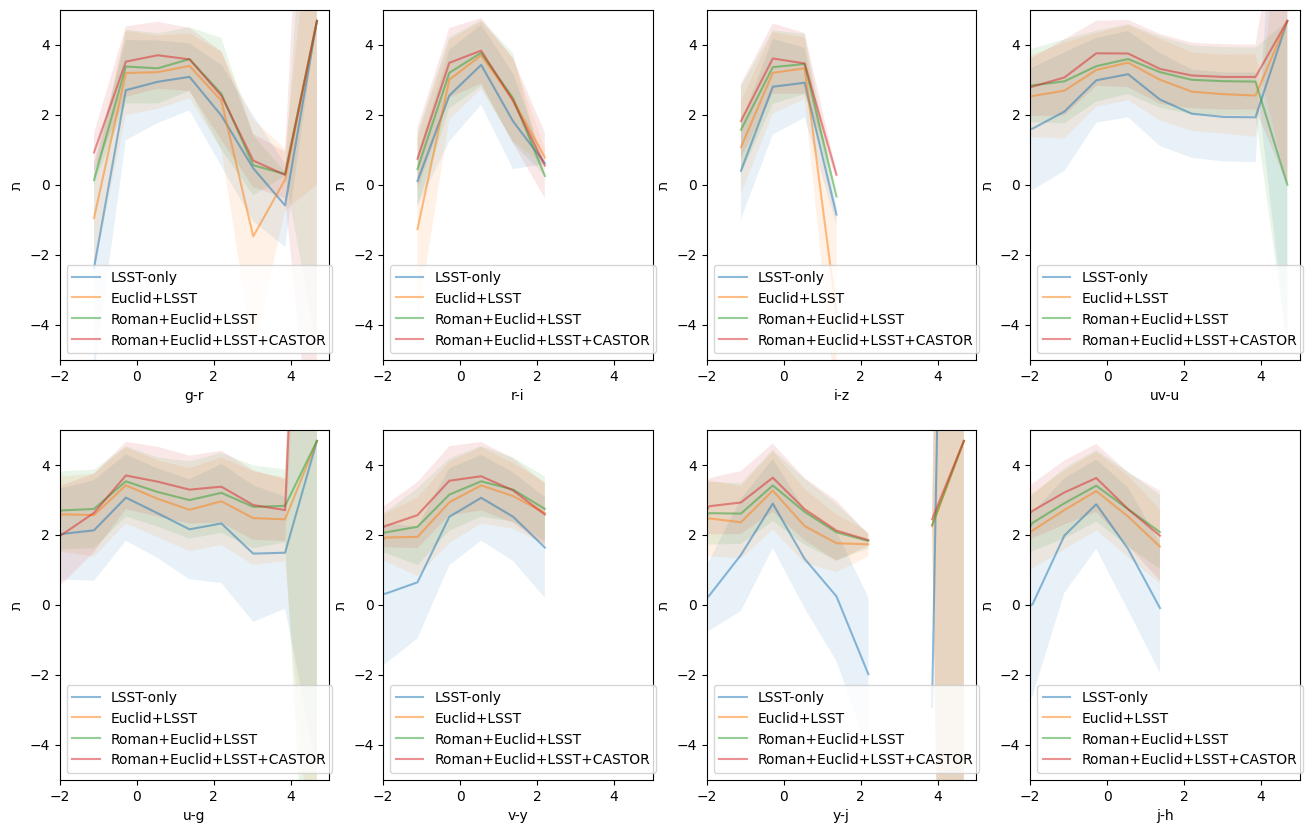

<Figure size 640x480 with 0 Axes>

In [ ]:
colors = ['g-r', 'r-i', 'i-z', 'uv-u', 'u-g', 'v-y', 'y-j', 'j-h']
fig, ax = plt.subplots(2, 4, figsize = (16, 10))


for color, ax in zip(colors, ax.reshape(-1)):

  for os in available_os:
    # print(os)
    color_bins = np.linspace(color_lim_min, color_lim_max, 10)

    plotran = np.empty_like(color_bins)
    ploterr = np.empty_like(color_bins)
  # print(catalogs[os].columns)
  # if 'logprob' not in catalogs[os].columns.values:
    catalogs[os]['logprob'] = all_tlm[os]
    # print(np.sum(np.isinf(all_tlm[os]))) #no nans in logprob
  # print(np.sum(np.isnan(plotran)))
    # print(catalogs[os].columns)
    for i, color_min in enumerate(color_bins[:-1]):
      color_max = color_bins[i+1]
      subset = catalogs[os][(catalogs["Roman+Euclid+LSST+CASTOR"][color] >= color_min) & (catalogs["Roman+Euclid+LSST+CASTOR"][color] <= color_max)]
    # print(len(subset))
    # print((color_min, len(subset), color_max))
      vals = subset['logprob']
    # print(np.max(vals))
    # print(len(vals))
      mean = np.mean(vals)
    # print(np.sum(np.isnan(mean)))
    # print(mean)
      std = np.std(vals)
      plotran[i] = mean
      ploterr[i] = std
    avgtav[os] = plotran
    errtav[os] = ploterr

    ax.plot(color_bins, avgtav[os], label=os, alpha=0.5)
    ax.fill_between(color_bins, avgtav[os] - errtav[os], avgtav[os] + errtav[os], alpha = 0.1)
  ax.legend()
  ax.set_xlabel(color)
  ax.set_ylabel(chr(0x05ea))
  ax.set_ylim(-5, 5)
  ax.set_xlim(-2, 5)
plt.show()

plt.savefig('color_space_plots.pdf')


LSST+CASTOR
0
Euclid+LSST
0
LSST+CASTOR
0
Euclid+LSST
0
LSST+CASTOR
0
Euclid+LSST
0
LSST+CASTOR
0
Euclid+LSST
0
LSST+CASTOR
0
Euclid+LSST
0
LSST+CASTOR
0
Euclid+LSST
0
LSST+CASTOR
0
Euclid+LSST
0
LSST+CASTOR
0
Euclid+LSST
0


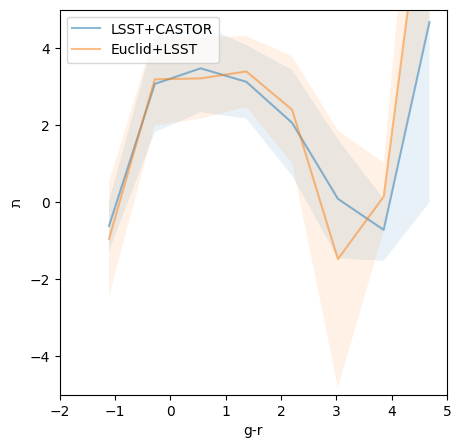

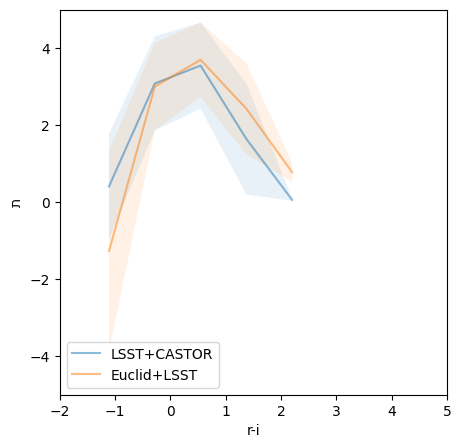

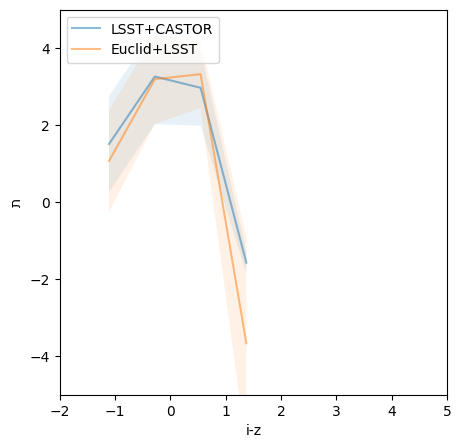

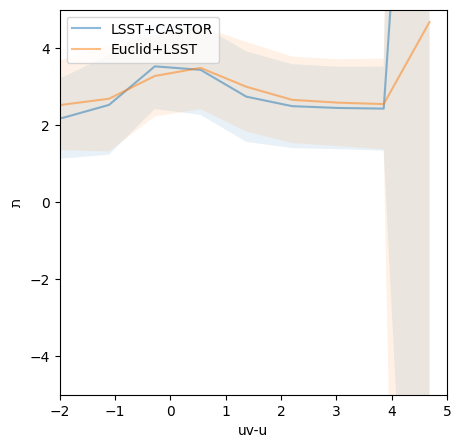

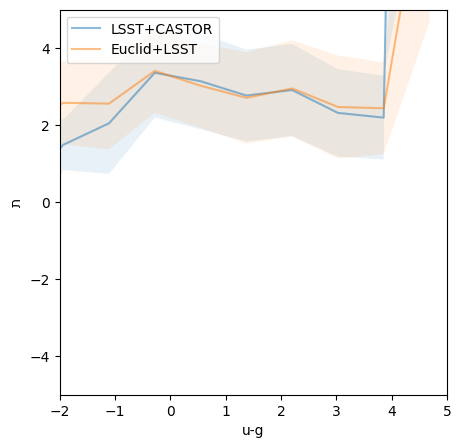

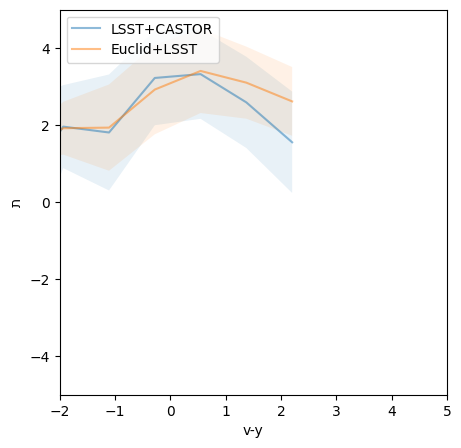

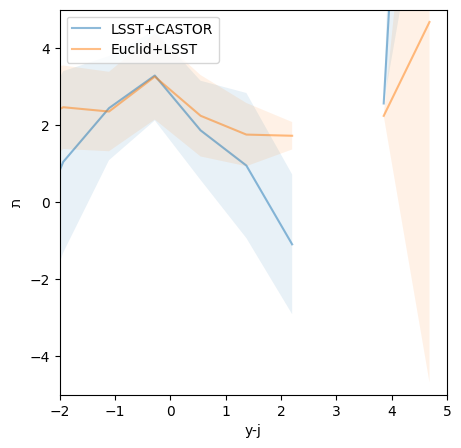

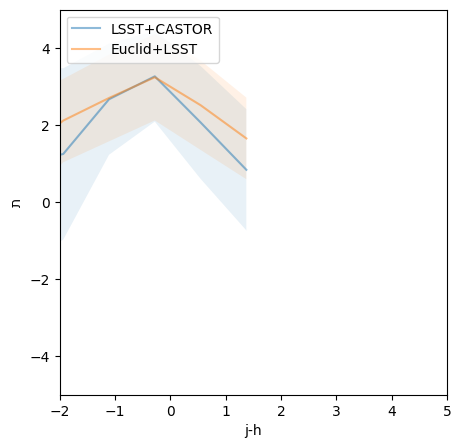

In [ ]:
colors = ['g-r', 'r-i', 'i-z', 'uv-u', 'u-g', 'v-y', 'y-j', 'j-h']

for color in colors:

  fig, ax = plt.subplots(1, 1, figsize = (5, 5))

  for os in comparison_os:
    print(os)
    color_bins = np.linspace(color_lim_min, color_lim_max, 10)

    plotran = np.empty_like(color_bins)
    ploterr = np.empty_like(color_bins)
  # print(catalogs[os].columns)
  # if 'logprob' not in catalogs[os].columns.values:
    catalogs[os]['logprob'] = all_tlm[os]
    print(np.sum(np.isinf(all_tlm[os]))) #no nans in logprob
  # print(np.sum(np.isnan(plotran)))
    # print(catalogs[os].columns)
    for i, color_min in enumerate(color_bins[:-1]):
      color_max = color_bins[i+1]
      subset = catalogs[os][(catalogs["Roman+Euclid+LSST+CASTOR"][color] >= color_min) & (catalogs["Roman+Euclid+LSST+CASTOR"][color] <= color_max)]
    # print(len(subset))
    # print((color_min, len(subset), color_max))
      vals = subset['logprob']
    # print(np.max(vals))
    # print(len(vals))
      mean = np.mean(vals)
    # print(np.sum(np.isnan(mean)))
    # print(mean)
      std = np.std(vals)
      plotran[i] = mean
      ploterr[i] = std
    avgtav[os] = plotran
    errtav[os] = ploterr

    ax.plot(color_bins, avgtav[os], label=os, alpha=0.5)
    ax.fill_between(color_bins, avgtav[os] - errtav[os], avgtav[os] + errtav[os], alpha = 0.1)
  ax.legend()
  ax.set_xlabel(color)
  ax.set_ylabel(chr(0x05ea))
  ax.set_ylim(-5, 5)
  ax.set_xlim(-2, 5)
plt.show()

In [ ]:
catalogs["Roman+Euclid+LSST+CASTOR"][(catalogs["Roman+Euclid+LSST+CASTOR"]['y-j'] >= 4) & (catalogs["Roman+Euclid+LSST+CASTOR"]['y-j'] <= 6)]

,z_true,r,g-r,r-i,i-z,v,v-y,y-j,j-h,g,uv-u,u-g,106,129 - 106,158-129,184-158,logprob
CASTOR_ID,,,,,,,,,,,,,,,,,
550477,0.2129,24.387169,0.092992,-0.045641,0.088472,24.386126,-3.91866,4.117239,-0.826725,24.60323,-0.268989,0.231679,24.342291,0.117665,0.08742,-0.136707,2.440986
